# Acknowledgements

Some routines in this code have been taken from:

the [Kaggle tutorial](https://www.kaggle.com/c/titanic/details/getting-started-with-python-ii)

["A Journey through Titanic"](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic) by Omar El Gabry.


In [1]:
# Import required packages
import pandas as pd
import numpy as np
import pylab as plt
import csv as csv
import seaborn as sns
from scipy import stats

# Import Cross Validation Score
from sklearn.model_selection import cross_val_score

# Import split tool
from sklearn.model_selection import train_test_split

# Import GridSearch
from sklearn.model_selection import GridSearchCV

# Import Student t-test
from scipy.stats import ttest_rel

# Import DummyClassifier
from sklearn.dummy import DummyClassifier

# Import the Random Forest package
from sklearn.ensemble import RandomForestClassifier

# Import the Support Vector Machines package
from sklearn import svm

# Import prepreprocessing
from sklearn import preprocessing

## Read in the training data

Read in the training data from the file `train.csv` in the same directory as the code.

In [2]:
# For .read_csv, always use header=0 when you know row 0 is the header row
train_df = pd.read_csv('train.csv', header=0)

# Examine the data - note that Age, Cabin and Embarked have missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Feature Extraction

### Examine Cabin data

Test the theory that the first letter of the cabin number may indicate where the passenger was on Titanic, and therefore may be correlated to their chance of survival.

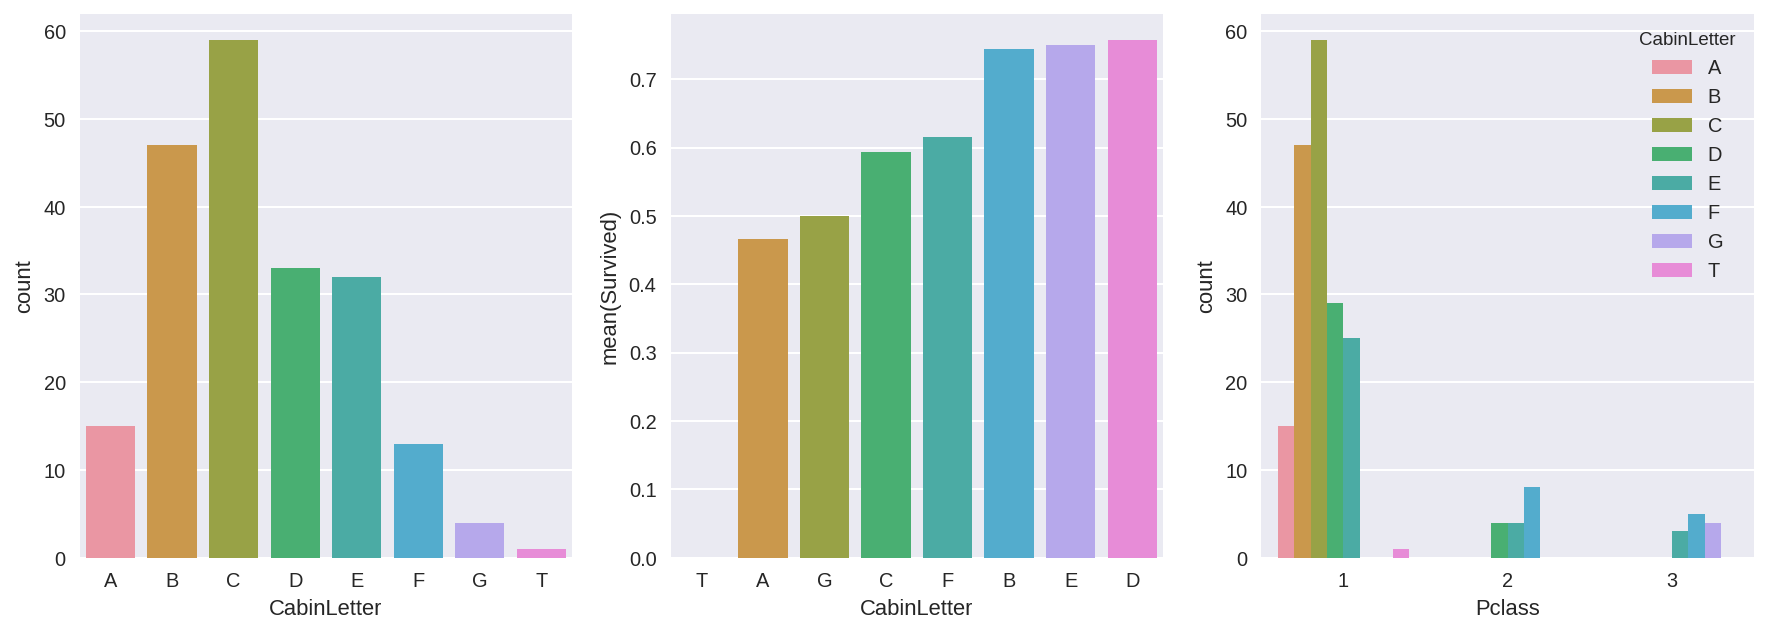

In [3]:
# Create a new column CabinLetter which is the first character of the Cabin string

train_df['CabinLetter'] = train_df['Cabin'].str[0]

plot_df = train_df[train_df['CabinLetter'].notnull()]

# Visualisation
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# Plot count of port of Embarkation
sns.countplot(x='CabinLetter', data=plot_df.sort_values(by='CabinLetter'), ax=axis1)

# Group by CabinLetter, and get the mean for survived passengers for each value in CabinLetter
cabin_perc = plot_df[['CabinLetter', 'Survived']].groupby(['CabinLetter'],as_index=False).mean()
sns.barplot(x='CabinLetter', y='Survived', data=cabin_perc.sort_values(by='Survived'),ax=axis2)

# Plot count of CabinLetter by Passenger Class
sns.countplot(x='Pclass', hue='CabinLetter', data=plot_df.sort_values(by='CabinLetter'), ax=axis3)

Some variation in survival rates by CabinLetter, but hard to deduce the missing values e.g. from Passenger Class

For Passenger Class 1, the CabinLetter can be anything from A-E

So drop the CabinLetter column

In [4]:
train_df = train_df.drop(['CabinLetter'], axis=1)

train_df.head(5)

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 
 
 
 
 0 
 1 
 0 
 3 
 Braund, Mr. Owen Harris 
 male 
 22.0 
 1 
 0 
 A/5 21171 
 7.2500 
 NaN 
 S 
 
 
 1 
 2 
 1 
 1 
 Cumings, Mrs. John Bradley (Florence Briggs Th... 
 female 
 38.0 
 1 
 0 
 PC 17599 
 71.2833 
 C85 
 C 
 
 
 2 
 3 
 1 
 3 
 Heikkinen, Miss. Laina 
 female 
 26.0 
 0 
 0 
 STON/O2. 3101282 
 7.9250 
 NaN 
 S 
 
 
 3 
 4 
 1 
 1 
 Futrelle, Mrs. Jacques Heath (Lily May Peel) 
 female 
 35.0 
 1 
 0 
 113803 
 53.1000 
 C123 
 S 
 
 
 4 
 5 
 0 
 3 
 Allen, Mr. William Henry 
 male 
 35.0 
 0 
 0 
 373450 
 8.0500 
 NaN 
 S

### Examine Sex data

Test the theory that the survival rate of the passenger may be related to their sex.

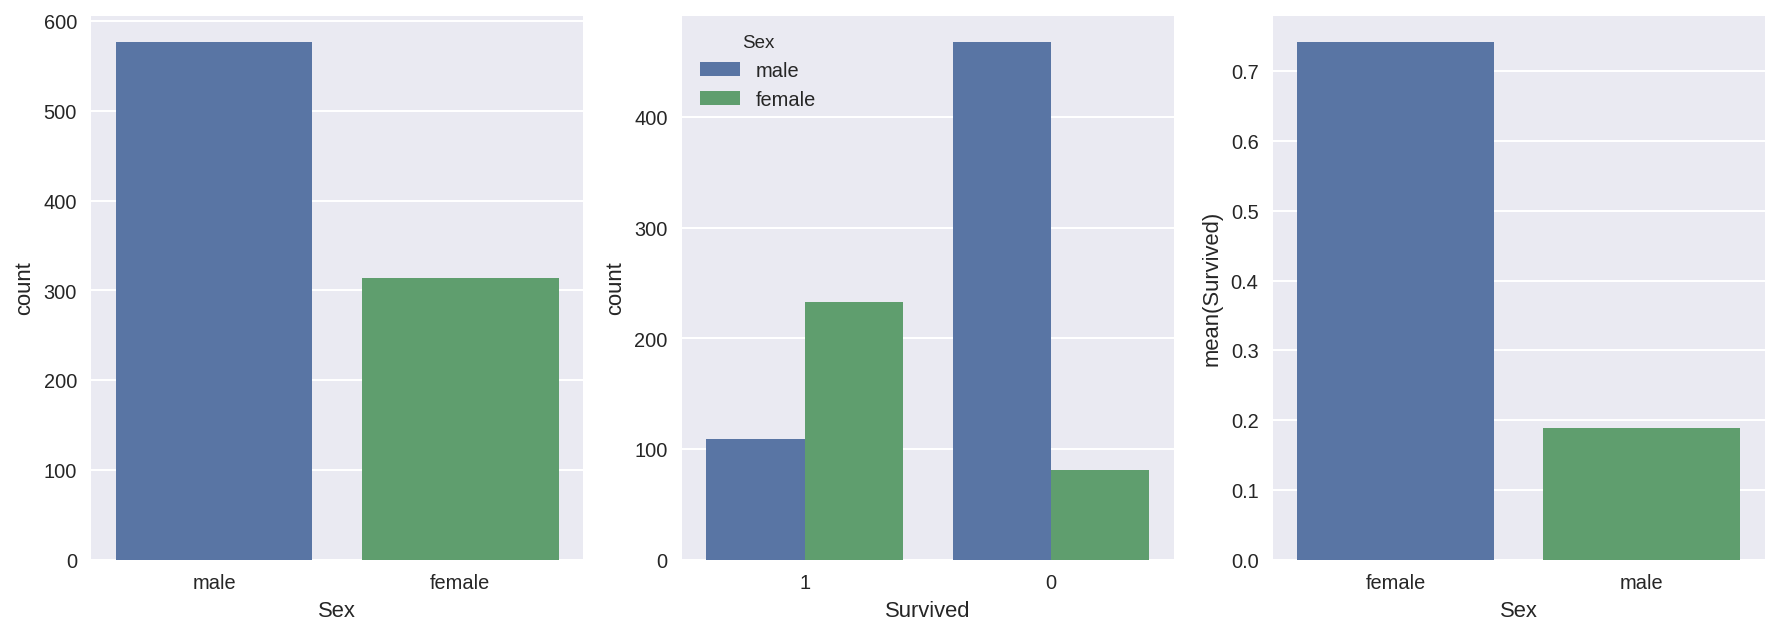

In [5]:
# Visualisation
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# Plot count of Sex
sns.countplot(x='Sex', data=train_df, ax=axis1)

# Plot count of Sex by Survival status
sns.countplot(x='Survived', hue='Sex', data=train_df, order=[1,0], ax=axis2)

# Group by sex, and get the mean for survived passengers for each value in Sex
sex_perc = train_df[['Sex', 'Survived']].groupby(['Sex'],as_index=False).mean()
sns.barplot(x='Sex', y='Survived', data=sex_perc,order=['female','male'],ax=axis3)

Sex makes a significant difference to mean Survival rate, so keep the data.

Create a numeric feature representation for Sex to be able to use it for Machine Learning, and call this new column Gender.

In [6]:
train_df['Gender'] = train_df['Sex'].map( {'female': 0, 'male': 1} ).astype(float)

train_df.head(5)

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 Gender 
 
 
 
 
 0 
 1 
 0 
 3 
 Braund, Mr. Owen Harris 
 male 
 22.0 
 1 
 0 
 A/5 21171 
 7.2500 
 NaN 
 S 
 1.0 
 
 
 1 
 2 
 1 
 1 
 Cumings, Mrs. John Bradley (Florence Briggs Th... 
 female 
 38.0 
 1 
 0 
 PC 17599 
 71.2833 
 C85 
 C 
 0.0 
 
 
 2 
 3 
 1 
 3 
 Heikkinen, Miss. Laina 
 female 
 26.0 
 0 
 0 
 STON/O2. 3101282 
 7.9250 
 NaN 
 S 
 0.0 
 
 
 3 
 4 
 1 
 1 
 Futrelle, Mrs. Jacques Heath (Lily May Peel) 
 female 
 35.0 
 1 
 0 
 113803 
 53.1000 
 C123 
 S 
 0.0 
 
 
 4 
 5 
 0 
 3 
 Allen, Mr. William Henry 
 male 
 35.0 
 0 
 0 
 373450 
 8.0500 
 NaN 
 S 
 1.0

### Examine Embarked data

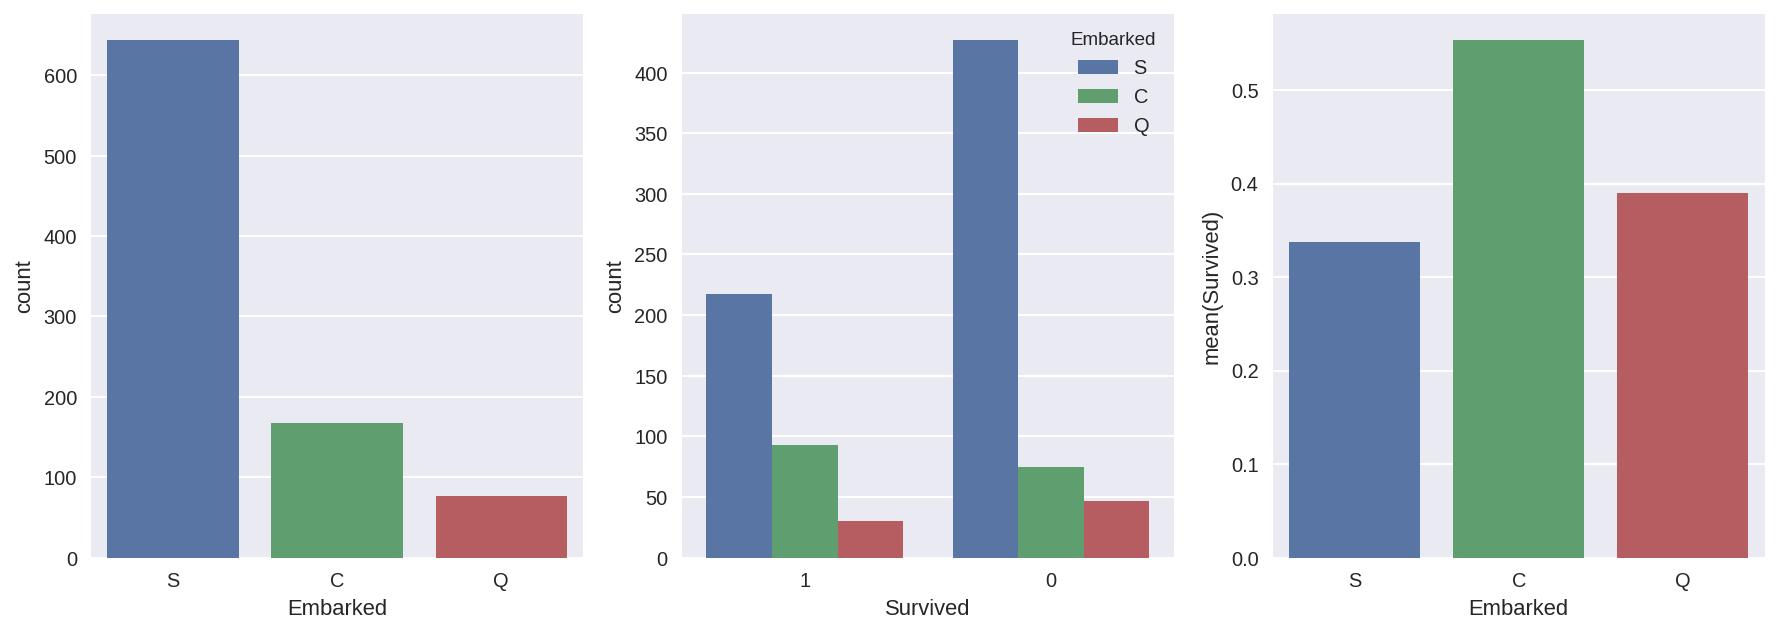

In [7]:
plot_df = train_df[train_df['Embarked'].notnull()]

# Visualisation
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# Plot count of port of Embarkation
sns.countplot(x='Embarked', data=plot_df, ax=axis1)

# Plot count of Embarked ports by Survival status
sns.countplot(x='Survived', hue='Embarked', data=plot_df, order=[1,0], ax=axis2)

# Group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = plot_df[['Embarked', 'Survived']].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

Create a numeric feature representation for Embarked - the missing values will be replaced with S (mapped to 0) as it is by far the most common port.

In [8]:
train_df['Port'] = train_df['Embarked'].fillna('S').map({'S': 0.0, 'C': 0.5, 'Q': 1.0}).astype(float)

train_df.head(5)

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 Gender 
 Port 
 
 
 
 
 0 
 1 
 0 
 3 
 Braund, Mr. Owen Harris 
 male 
 22.0 
 1 
 0 
 A/5 21171 
 7.2500 
 NaN 
 S 
 1.0 
 0.0 
 
 
 1 
 2 
 1 
 1 
 Cumings, Mrs. John Bradley (Florence Briggs Th... 
 female 
 38.0 
 1 
 0 
 PC 17599 
 71.2833 
 C85 
 C 
 0.0 
 0.5 
 
 
 2 
 3 
 1 
 3 
 Heikkinen, Miss. Laina 
 female 
 26.0 
 0 
 0 
 STON/O2. 3101282 
 7.9250 
 NaN 
 S 
 0.0 
 0.0 
 
 
 3 
 4 
 1 
 1 
 Futrelle, Mrs. Jacques Heath (Lily May Peel) 
 female 
 35.0 
 1 
 0 
 113803 
 53.1000 
 C123 
 S 
 0.0 
 0.0 
 
 
 4 
 5 
 0 
 3 
 Allen, Mr. William Henry 
 male 
 35.0 
 0 
 0 
 373450 
 8.0500 
 NaN 
 S 
 1.0 
 0.0

### Examine Fare data

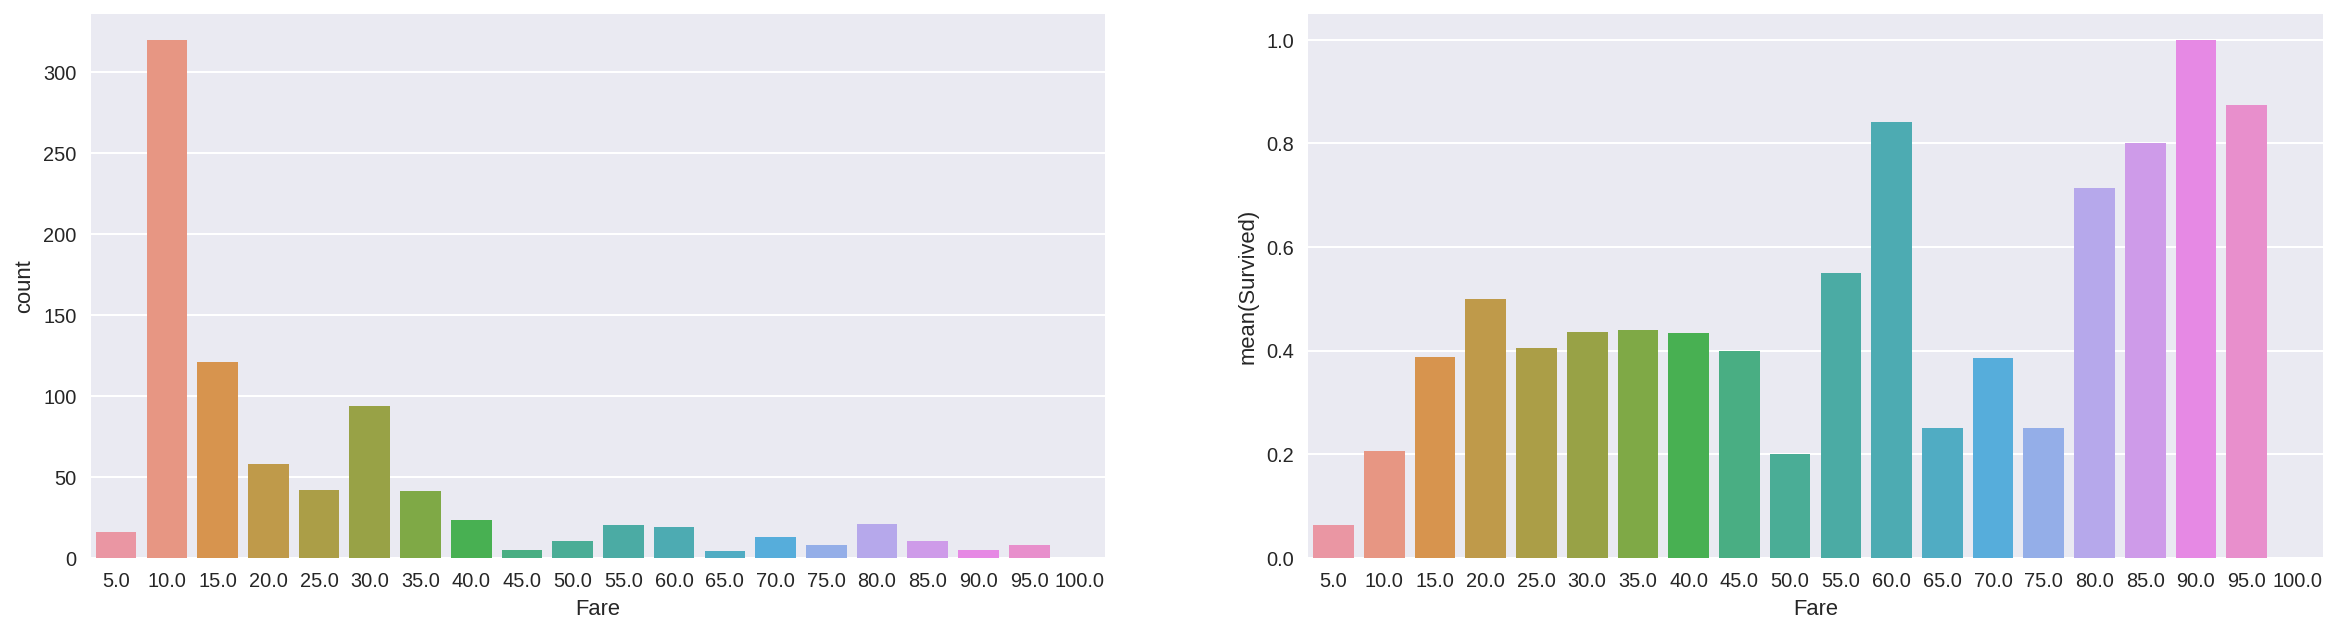

In [9]:
fare_bin_size = 5

bin_count, bin_edges, binnumber = stats.binned_statistic(train_df['Fare'], train_df['Fare'], statistic='count', bins=100/fare_bin_size, range=(0,100))
bin_means, bin_edges, binnumber = stats.binned_statistic(train_df['Fare'], train_df['Survived'], statistic='mean', bins=100/fare_bin_size, range=(0,100))

fare_survived_df = pd.DataFrame({'FareBin': bin_edges[1:], 'FareCount': bin_count, 'MeanSurv': bin_means})

# Visualisation
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,5))

axes = sns.barplot(x='FareBin', y='FareCount', data=fare_survived_df, ax=axis1)
axes.set(xlabel = 'Fare', ylabel = 'count')

axes = sns.barplot(x='FareBin', y='MeanSurv', data=fare_survived_df, ax=axis2)
axes.set(xlabel = 'Fare', ylabel = 'mean(Survived)')

### Examine Age data

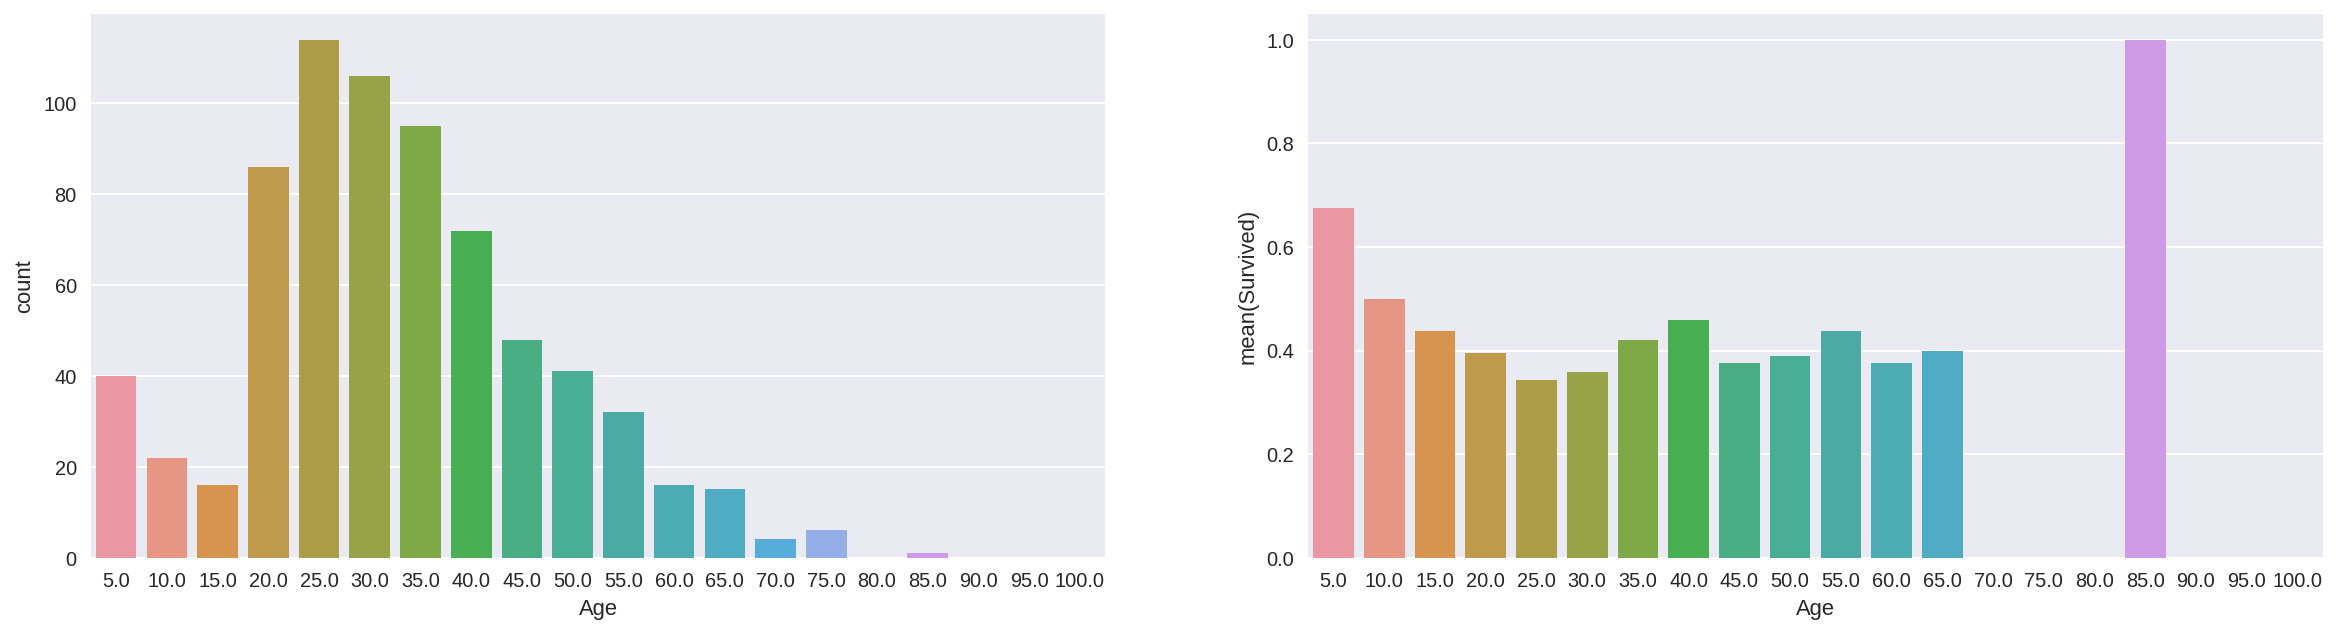

In [10]:
age_bin_size = 5

bin_count, bin_edges, binnumber = stats.binned_statistic(train_df['Age'], train_df['Age'], statistic='count', bins=100/age_bin_size, range=(0,100))
bin_means, bin_edges, binnumber = stats.binned_statistic(train_df['Age'], train_df['Survived'], statistic='mean', bins=100/age_bin_size, range=(0,100))

age_survived_df = pd.DataFrame({'AgeBin': bin_edges[1:], 'AgeCount': bin_count, 'MeanSurv': bin_means})

# Visualisation
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,5))

axes = sns.barplot(x='AgeBin', y='AgeCount', data=age_survived_df, ax=axis1)
axes.set(xlabel = 'Age', ylabel = 'count')

axes = sns.barplot(x='AgeBin', y='MeanSurv', data=age_survived_df, ax=axis2)
axes.set(xlabel = 'Age', ylabel = 'mean(Survived)')


Age appears to make a difference to mean Survival rate, so keep the data.

To use Age as a feature, we need to handle the passengers with missing age details.

In [11]:
agena_df = train_df[train_df['Age'].isnull()]
agena_df.head(5)

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 Gender 
 Port 
 
 
 
 
 5 
 6 
 0 
 3 
 Moran, Mr. James 
 male 
 NaN 
 0 
 0 
 330877 
 8.4583 
 NaN 
 Q 
 1.0 
 1.0 
 
 
 17 
 18 
 1 
 2 
 Williams, Mr. Charles Eugene 
 male 
 NaN 
 0 
 0 
 244373 
 13.0000 
 NaN 
 S 
 1.0 
 0.0 
 
 
 19 
 20 
 1 
 3 
 Masselmani, Mrs. Fatima 
 female 
 NaN 
 0 
 0 
 2649 
 7.2250 
 NaN 
 C 
 0.0 
 0.5 
 
 
 26 
 27 
 0 
 3 
 Emir, Mr. Farred Chehab 
 male 
 NaN 
 0 
 0 
 2631 
 7.2250 
 NaN 
 C 
 1.0 
 0.5 
 
 
 28 
 29 
 1 
 3 
 O'Dwyer, Miss. Ellen "Nellie" 
 female 
 NaN 
 0 
 0 
 330959 
 7.8792 
 NaN 
 Q 
 0.0 
 1.0

Can we get a good estimate of a passenger's missing age from other feature data?

Is there any relationship beween age and passenger class?

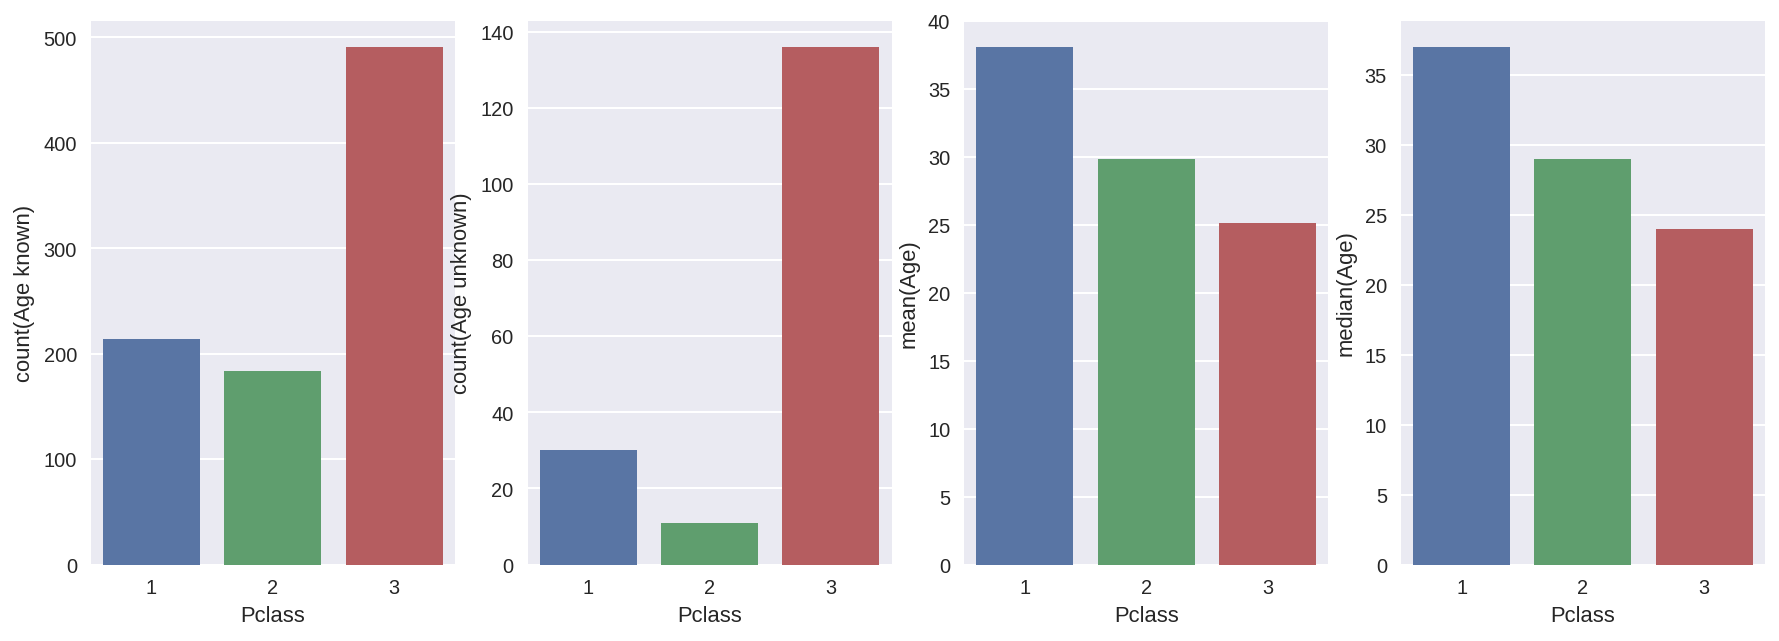

In [12]:
# Distribution of Pclass values among passengers, where age is known
count_Pclass = plot_df[['Pclass', 'PassengerId']].groupby(['Pclass'],as_index=False).count()

# Distribution of Pclass values among passengers, where age is unknown
count_agena_Pclass = agena_df[['Pclass', 'PassengerId']].groupby(['Pclass'],as_index=False).count()

# Mean and median age of passengers by Pclass value
mean_age = plot_df[['Pclass', 'Age']].groupby(['Pclass'],as_index=False).mean()
median_age = plot_df[['Pclass', 'Age']].groupby(['Pclass'],as_index=False).median()

# Visualisation
fig, (axis1,axis2,axis3,axis4) = plt.subplots(1,4,figsize=(15,5))

axes = sns.barplot(x='Pclass', y='PassengerId', data=count_Pclass, ax=axis1)
axes.set(ylabel = 'count(Age known)')

axes = sns.barplot(x='Pclass', y='PassengerId', data=count_agena_Pclass, ax=axis2)
axes.set(ylabel = 'count(Age unknown)')

sns.barplot(x='Pclass', y='Age', data=mean_age, ax=axis3)

axes = sns.barplot(x='Pclass', y='Age', data=median_age, ax=axis4)
axes.set(ylabel = 'median(Age)')

Is there any relationship between age and fare paid?

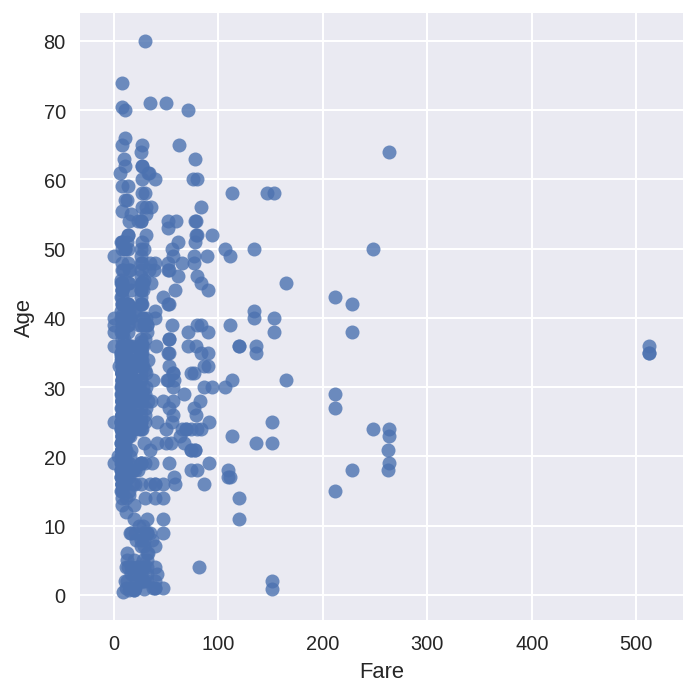

In [13]:
axes = sns.lmplot('Fare', 'Age', data=plot_df, fit_reg=False)

axes.set(xlabel="Fare", ylabel="Age")

Is there any relationship beween age and sex?

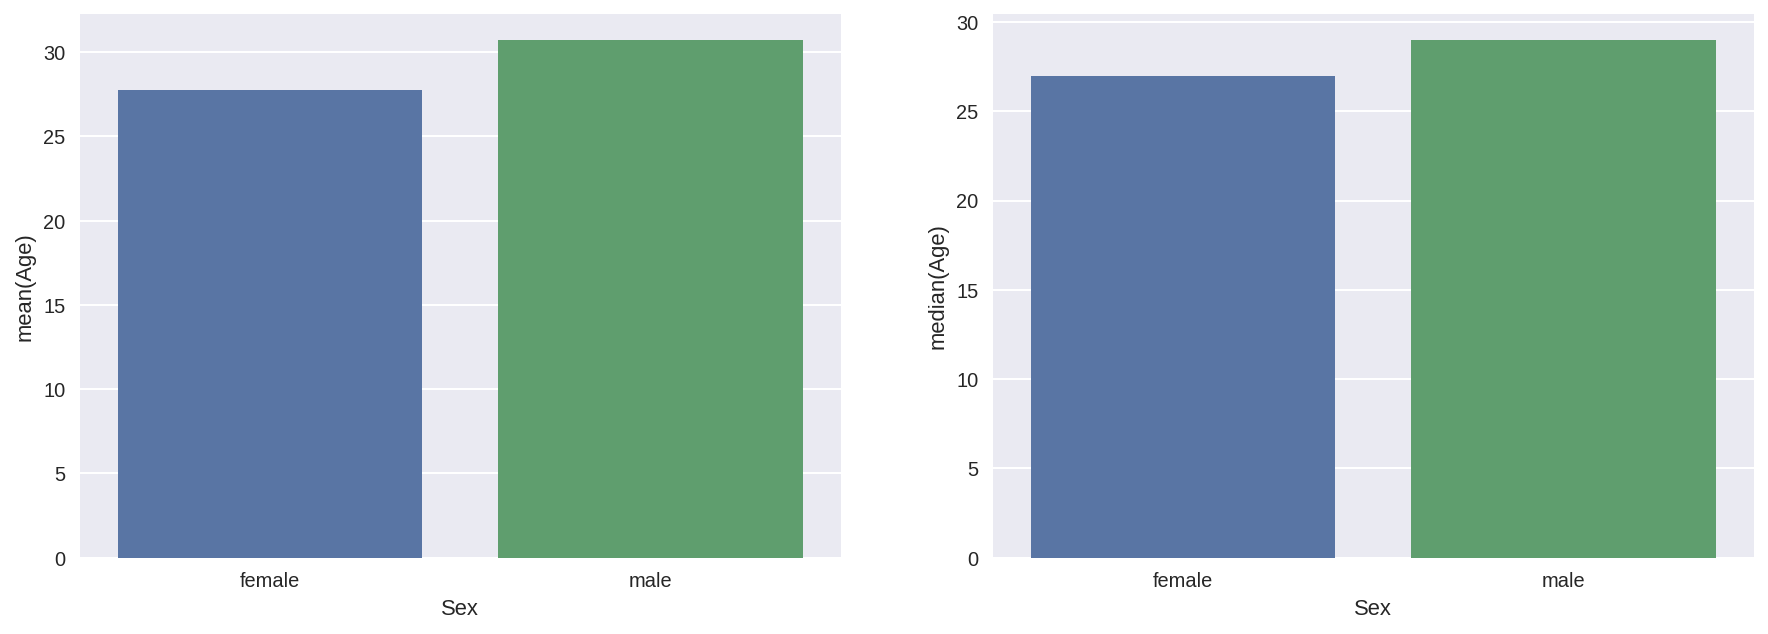

In [14]:
# Visualisation
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))

mean_age = plot_df[['Sex', 'Age']].groupby(['Sex'],as_index=False).mean()
median_age = plot_df[['Sex', 'Age']].groupby(['Sex'],as_index=False).median()
sns.barplot(x='Sex', y='Age', data=mean_age, ax=axis1)
axes = sns.barplot(x='Sex', y='Age', data=median_age, ax=axis2)
axes.set(ylabel = 'median(Age)')

Is there any relationship between age and sibling/spouse?

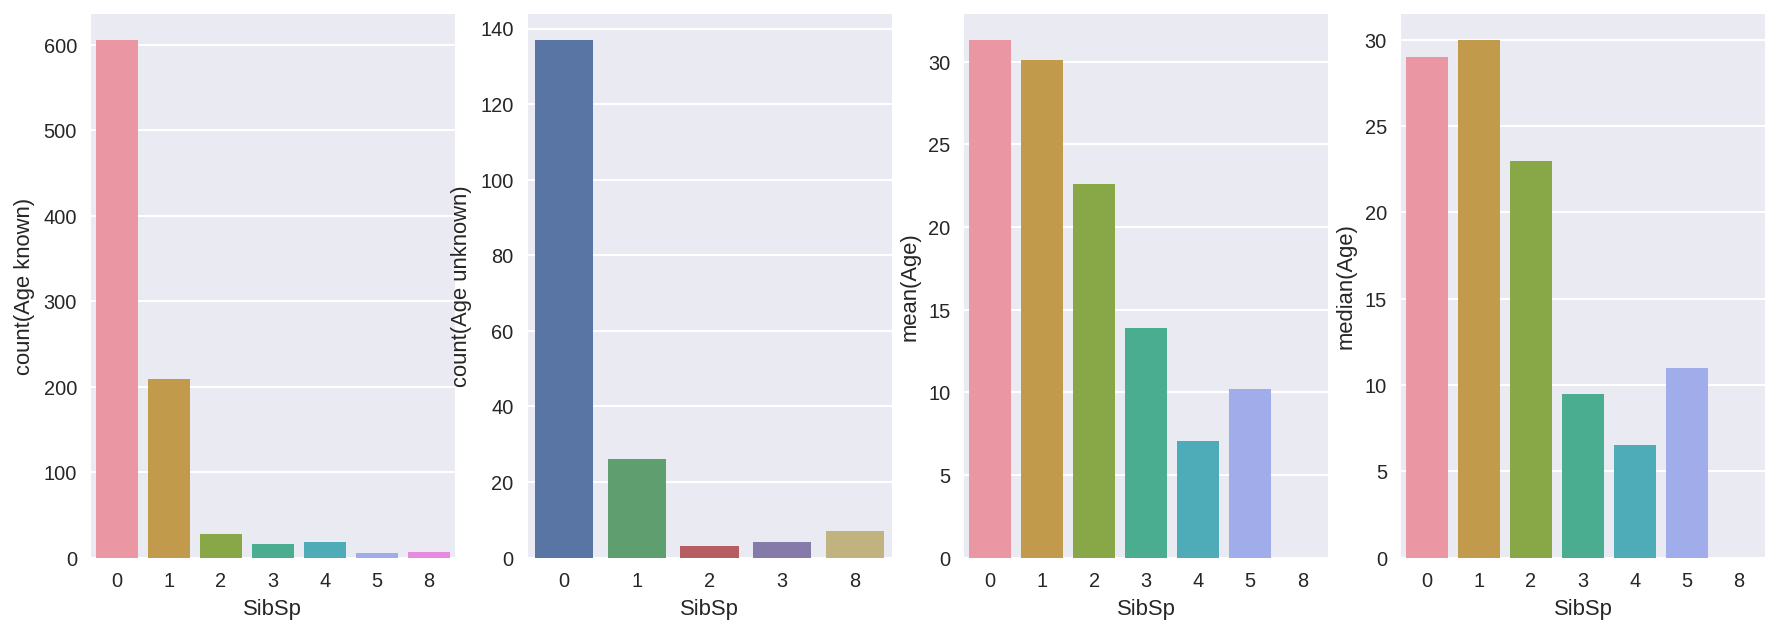

In [15]:
# Distribution of SibSp values among passengers, where age is known
count_sibsp = plot_df[['SibSp', 'PassengerId']].groupby(['SibSp'],as_index=False).count()

# Distribution of SibSp values among passengers, where age is unknown
count_agena_sibsp = agena_df[['SibSp', 'PassengerId']].groupby(['SibSp'],as_index=False).count()

# Mean and median age of passengers by SibSp value
mean_age = plot_df[['SibSp', 'Age']].groupby(['SibSp'],as_index=False).mean()
median_age = plot_df[['SibSp', 'Age']].groupby(['SibSp'],as_index=False).median()

# Visualisation
fig, (axis1,axis2,axis3,axis4) = plt.subplots(1,4,figsize=(15,5))

axes = sns.barplot(x='SibSp', y='PassengerId', data=count_sibsp, ax=axis1)
axes.set(ylabel = 'count(Age known)')

axes = sns.barplot(x='SibSp', y='PassengerId', data=count_agena_sibsp, ax=axis2)
axes.set(ylabel = 'count(Age unknown)')

sns.barplot(x='SibSp', y='Age', data=mean_age, ax=axis3)

axes = sns.barplot(x='SibSp', y='Age', data=median_age, ax=axis4)
axes.set(ylabel = 'median(Age)')

Is there any relationship between age and parent/child?

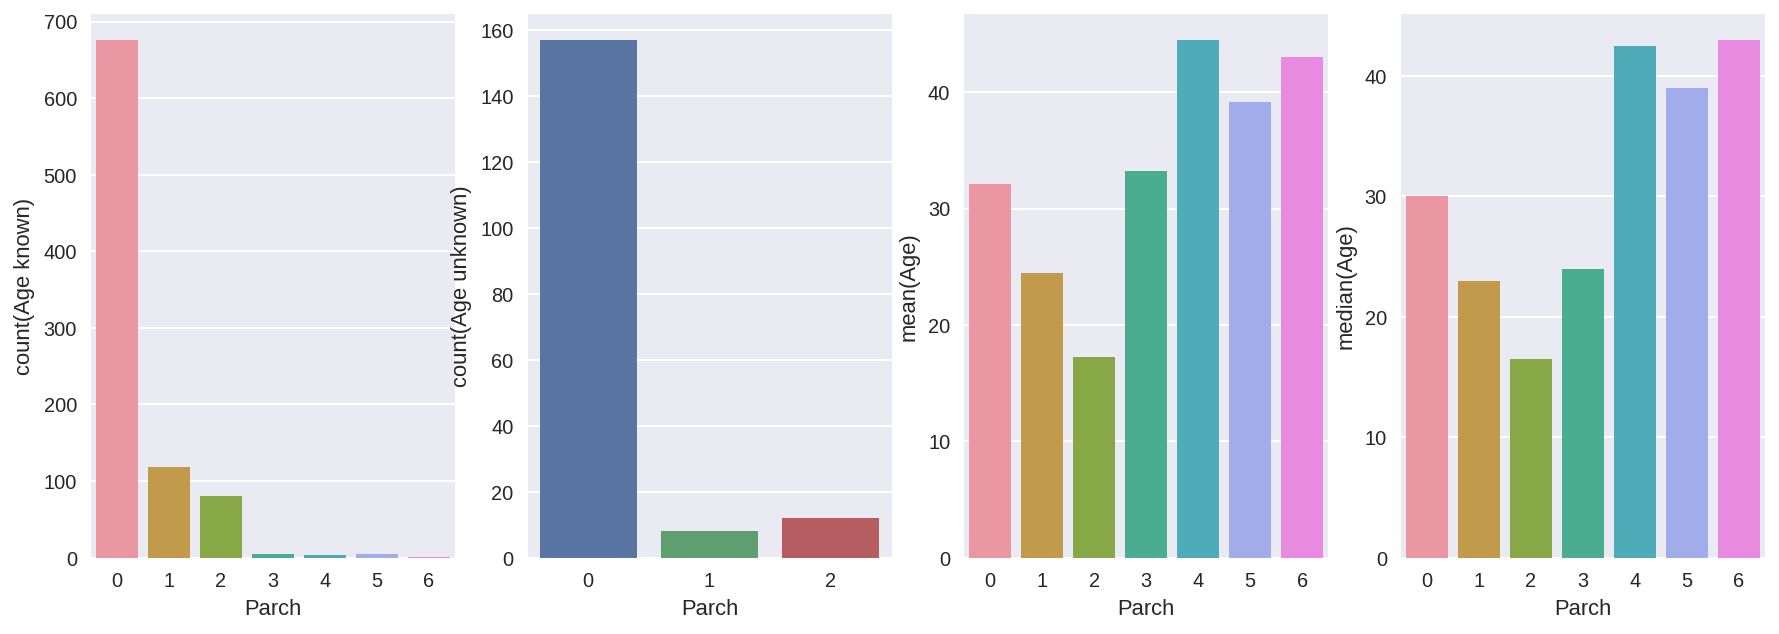

In [16]:
# Distribution of Parch values among passengers, where age is known
count_Parch = plot_df[['Parch', 'PassengerId']].groupby(['Parch'],as_index=False).count()

# Distribution of Parch values among passengers, where age is unknown
count_agena_Parch = agena_df[['Parch', 'PassengerId']].groupby(['Parch'],as_index=False).count()

# Mean and median age of passengers by Parch value
mean_age = plot_df[['Parch', 'Age']].groupby(['Parch'],as_index=False).mean()
median_age = plot_df[['Parch', 'Age']].groupby(['Parch'],as_index=False).median()

# Visualisation
fig, (axis1,axis2,axis3,axis4) = plt.subplots(1,4,figsize=(15,5))

axes = sns.barplot(x='Parch', y='PassengerId', data=count_Parch, ax=axis1)
axes.set(ylabel = 'count(Age known)')

axes = sns.barplot(x='Parch', y='PassengerId', data=count_agena_Parch, ax=axis2)
axes.set(ylabel = 'count(Age unknown)')

sns.barplot(x='Parch', y='Age', data=mean_age, ax=axis3)

axes = sns.barplot(x='Parch', y='Age', data=median_age, ax=axis4)
axes.set(ylabel = 'median(Age)')

Set the missing age values to Median age for each passenger class

In [17]:
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = train_df[(train_df['Gender'] == i) & (train_df['Pclass'] == j+1)]['Age'].dropna().median()
 
train_df['AgeFill'] = train_df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        train_df.loc[ (train_df.Age.isnull()) & (train_df.Gender == i) & (train_df.Pclass == j+1),'AgeFill'] = median_ages[i,j]
        
# Drop ages 80 or over as outliers from this data set

train_df = train_df[train_df['Age']<80]

# Scale from 0 to 1 - normalize at 100 because we won't be able to drop any ages over 80 from the test data set

train_df['AgeFill'] = train_df['AgeFill']/100

train_df[train_df['Age'].isnull()].head(5)

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 Gender 
 Port 
 AgeFill

### Examine Sibling/Spouse (SibSp) data

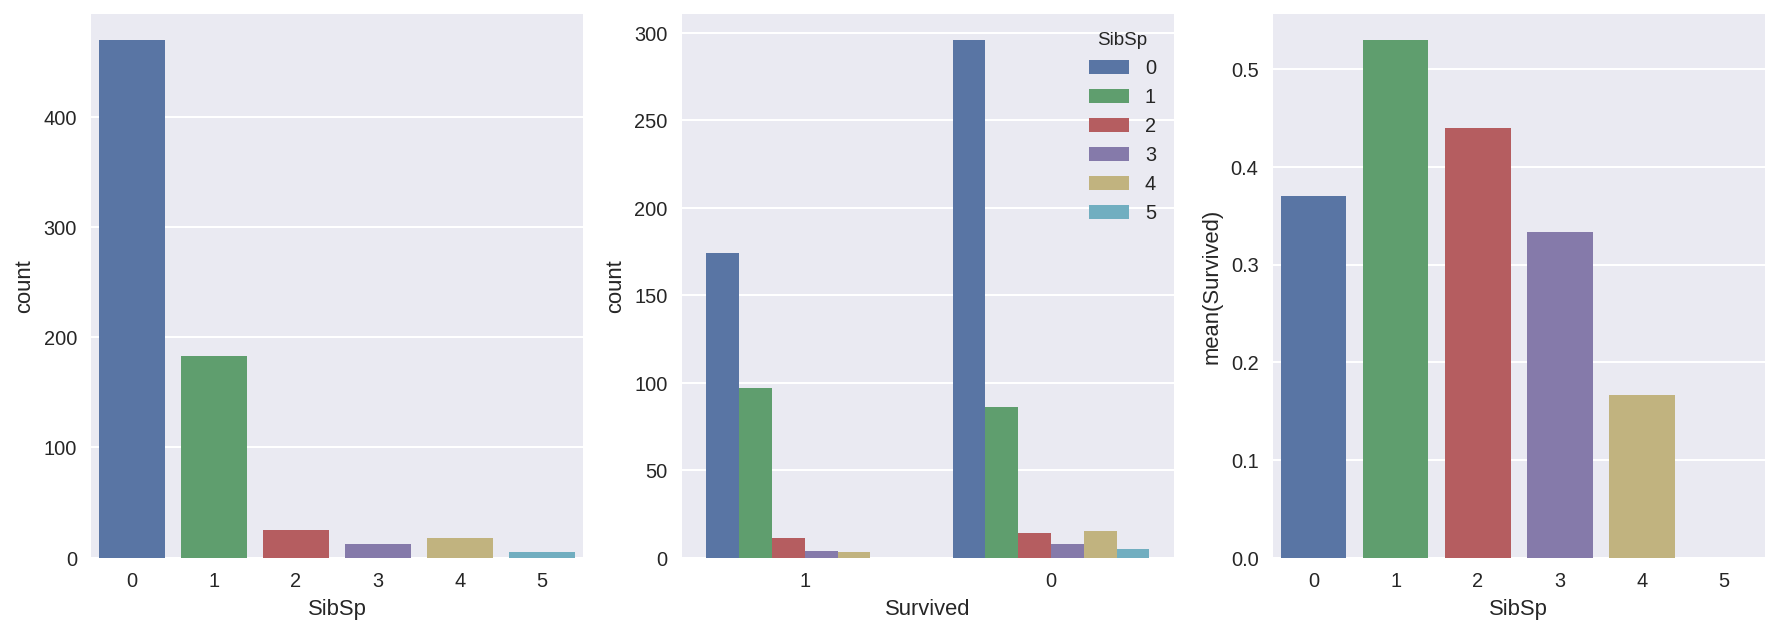

In [18]:
# Visualisation
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# Plot count of port of Embarkation
sns.countplot(x='SibSp', data=train_df, ax=axis1)

# Plot count of Embarked ports by Survival status
sns.countplot(x='Survived', hue='SibSp', data=train_df, order=[1,0], ax=axis2)

# Group by embarked, and get the mean for survived passengers for each value in SibSp
sibsp_mean = train_df[['SibSp', 'Survived']].groupby(['SibSp'],as_index=False).mean()
sns.barplot(x='SibSp', y='Survived', data=sibsp_mean,ax=axis3)

### Examine Parent/Child (Parch) data

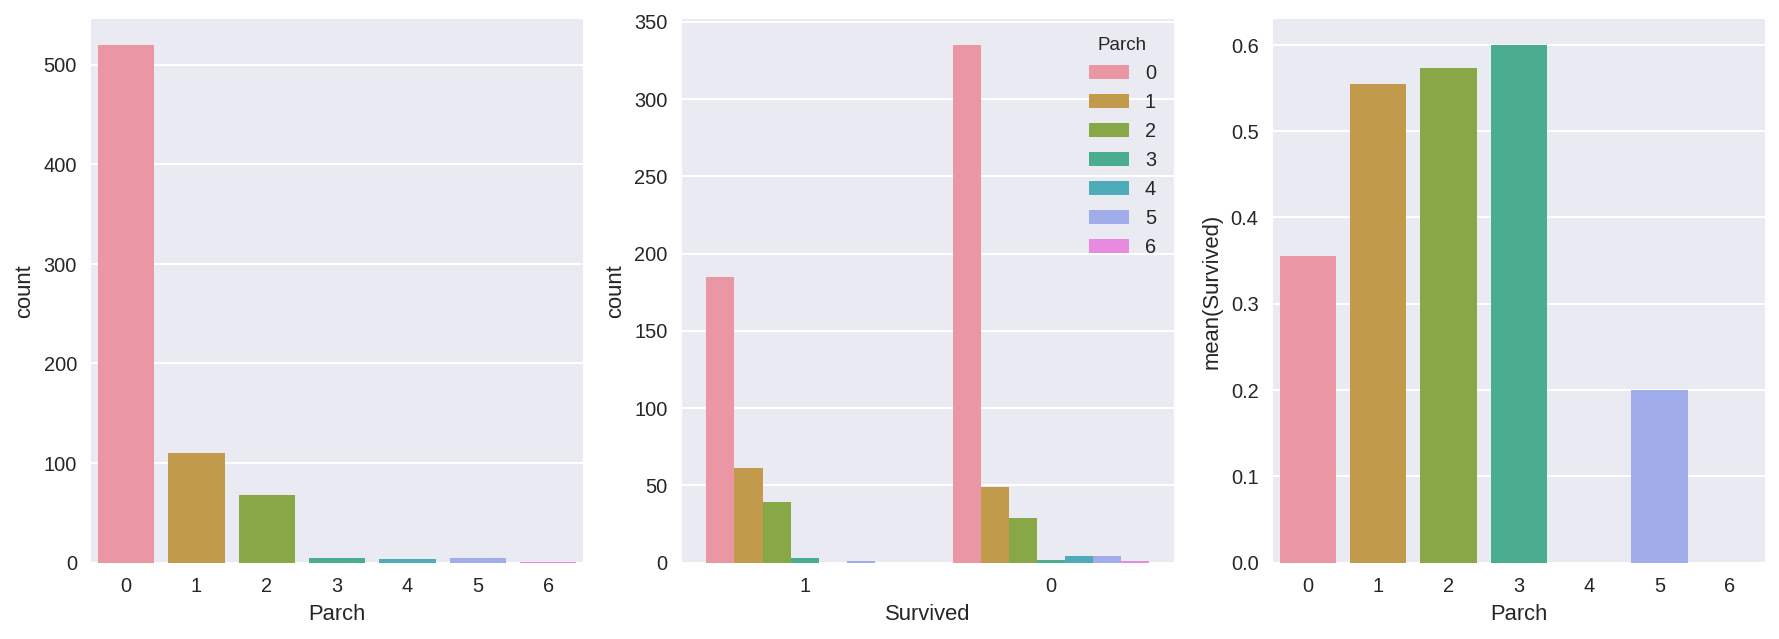

In [19]:
# Visualisation
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# Plot count of port of Embarkation
sns.countplot(x='Parch', data=train_df, ax=axis1)

# Plot count of Embarked ports by Survival status
sns.countplot(x='Survived', hue='Parch', data=train_df, order=[1,0], ax=axis2)

# Group by embarked, and get the mean for survived passengers for each value in Parch
parch_mean = train_df[['Parch', 'Survived']].groupby(['Parch'],as_index=False).mean()
sns.barplot(x='Parch', y='Survived', data=parch_mean,ax=axis3)

Both SibSp and Parch appear to make a difference to a passenger's chance of surviving - for non-zero values the chances are higher.

However, there are not very many non-zero values of each.  Try combining the two into a new column for total family size.

In [20]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch']

train_df.head(10)

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 Gender 
 Port 
 AgeFill 
 FamilySize 
 
 
 
 
 0 
 1 
 0 
 3 
 Braund, Mr. Owen Harris 
 male 
 22.0 
 1 
 0 
 A/5 21171 
 7.2500 
 NaN 
 S 
 1.0 
 0.0 
 0.22 
 1 
 
 
 1 
 2 
 1 
 1 
 Cumings, Mrs. John Bradley (Florence Briggs Th... 
 female 
 38.0 
 1 
 0 
 PC 17599 
 71.2833 
 C85 
 C 
 0.0 
 0.5 
 0.38 
 1 
 
 
 2 
 3 
 1 
 3 
 Heikkinen, Miss. Laina 
 female 
 26.0 
 0 
 0 
 STON/O2. 3101282 
 7.9250 
 NaN 
 S 
 0.0 
 0.0 
 0.26 
 0 
 
 
 3 
 4 
 1 
 1 
 Futrelle, Mrs. Jacques Heath (Lily May Peel) 
 female 
 35.0 
 1 
 0 
 113803 
 53.1000 
 C123 
 S 
 0.0 
 0.0 
 0.35 
 1 
 
 
 4 
 5 
 0 
 3 
 Allen, Mr. William Henry 
 male 
 35.0 
 0 
 0 
 373450 
 8.0500 
 NaN 
 S 
 1.0 
 0.0 
 0.35 
 0 
 
 
 6 
 7 
 0 
 1 
 McCarthy, Mr. Timothy J 
 male 
 54.0 
 0 
 0 
 17463 
 51.8625 
 E46 
 S 
 1.0 
 0.0 
 0.54 
 0 
 
 
 7 
 8 
 0 
 3 
 Palsson, Master. Gosta Leonard 
 male 
 2.0 
 3 
 1 
 349909 
 21.0750 
 NaN 
 S 
 1.0 
 0.0 
 0.02 
 4 
 
 
 8 
 9 
 1 
 3 
 Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg) 
 female 
 27.0 
 0 
 2 
 347742 
 11.1333 
 NaN 
 S 
 0.0 
 0.0 
 0.27 
 2 
 
 
 9 
 10 
 1 
 2 
 Nasser, Mrs. Nicholas (Adele Achem) 
 female 
 14.0 
 1 
 0 
 237736 
 30.0708 
 NaN 
 C 
 0.0 
 0.5 
 0.14 
 1 
 
 
 10 
 11 
 1 
 3 
 Sandstrom, Miss. Marguerite Rut 
 female 
 4.0 
 1 
 1 
 PP 9549 
 16.7000 
 G6 
 S 
 0.0 
 0.0 
 0.04 
 2

### Examine FamilySize data

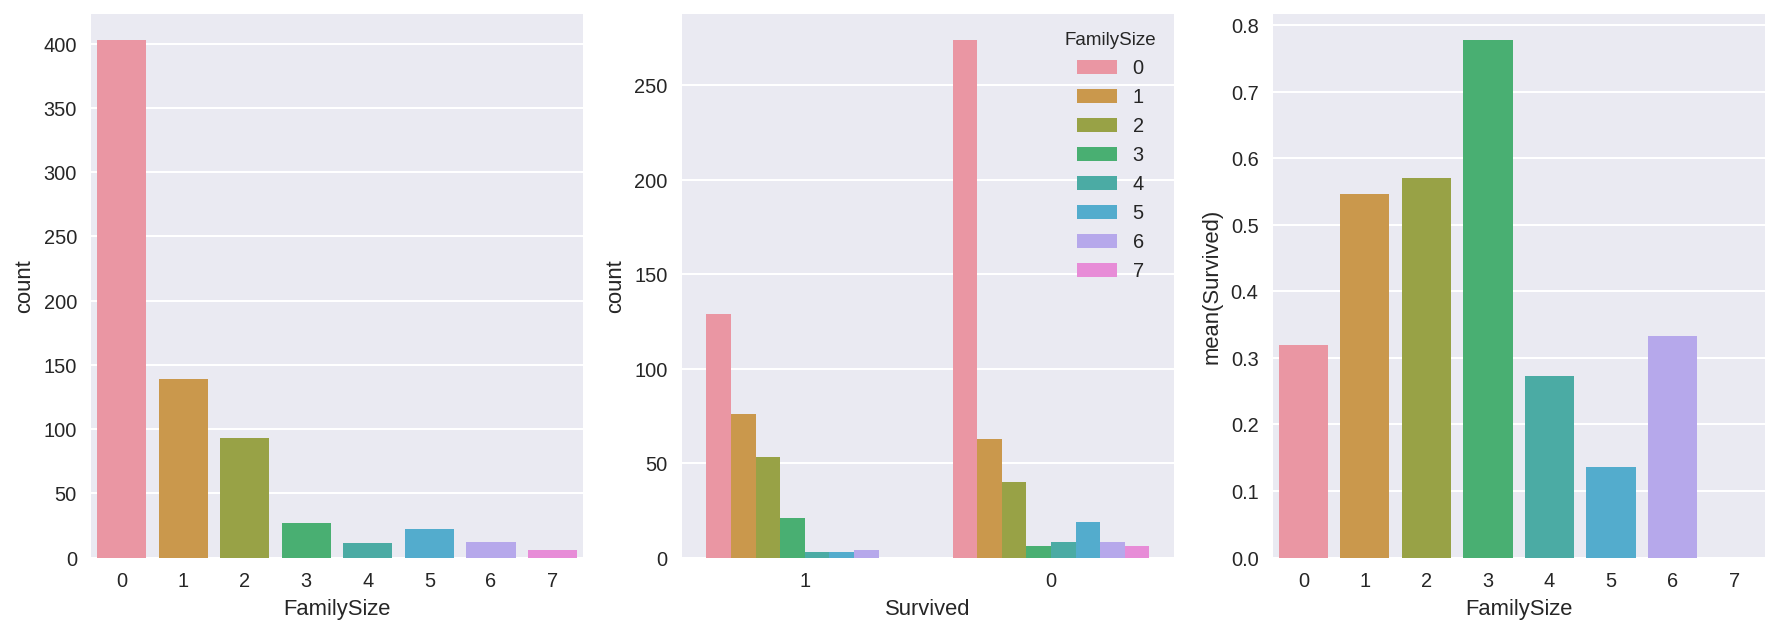

In [21]:
# Visualisation
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# Plot count of port of Embarkation
sns.countplot(x='FamilySize', data=train_df, ax=axis1)

# Plot count of Embarked ports by Survival status
sns.countplot(x='Survived', hue='FamilySize', data=train_df, order=[1,0], ax=axis2)

# Group by embarked, and get the mean for survived passengers for each value in FamilySize
familysize_mean = train_df[['FamilySize', 'Survived']].groupby(['FamilySize'],as_index=False).mean()
sns.barplot(x='FamilySize', y='Survived', data=familysize_mean,ax=axis3)

## Feature Scaling

Scale SibSp, Parch, FamilySize, Pclass and Fare

In [22]:
train_df['SibSpS'] = preprocessing.robust_scale(train_df['SibSp'])
train_df['ParchS'] = preprocessing.robust_scale(train_df['Parch'])
train_df['FamilySizeS'] = preprocessing.robust_scale(train_df['FamilySize'])
train_df['PclassS'] = preprocessing.robust_scale(train_df['Pclass'])
train_df['FareS'] = preprocessing.robust_scale(train_df['Fare'])

train_df

/projects/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data 

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 ... 
 Embarked 
 Gender 
 Port 
 AgeFill 
 FamilySize 
 SibSpS 
 ParchS 
 FamilySizeS 
 PclassS 
 FareS 
 
 
 
 
 0 
 1 
 0 
 3 
 Braund, Mr. Owen Harris 
 male 
 22.0 
 1 
 0 
 A/5 21171 
 7.2500 
 ... 
 S 
 1.0 
 0.0 
 0.22 
 1 
 1.0 
 0.0 
 1.0 
 0.5 
 -0.333662 
 
 
 1 
 2 
 1 
 1 
 Cumings, Mrs. John Bradley (Florence Briggs Th... 
 female 
 38.0 
 1 
 0 
 PC 17599 
 71.2833 
 ... 
 C 
 0.0 
 0.5 
 0.38 
 1 
 1.0 
 0.0 
 1.0 
 -0.5 
 2.182381 
 
 
 2 
 3 
 1 
 3 
 Heikkinen, Miss. Laina 
 female 
 26.0 
 0 
 0 
 STON/O2. 3101282 
 7.9250 
 ... 
 S 
 0.0 
 0.0 
 0.26 
 0 
 0.0 
 0.0 
 0.0 
 0.5 
 -0.307139 
 
 
 3 
 4 
 1 
 1 
 Futrelle, Mrs. Jacques Heath (Lily May Peel) 
 female 
 35.0 
 1 
 0 
 113803 
 53.1000 
 ... 
 S 
 0.0 
 0.0 
 0.35 
 1 
 1.0 
 0.0 
 1.0 
 -0.5 
 1.467910 
 
 
 4 
 5 
 0 
 3 
 Allen, Mr. William Henry 
 male 
 35.0 
 0 
 0 
 373450 
 8.0500 
 ... 
 S 
 1.0 
 0.0 
 0.35 
 0 
 0.0 
 0.0 
 0.0 
 0.5 
 -0.302228 
 
 
 6 
 7 
 0 
 1 
 McCarthy, Mr. Timothy J 
 male 
 54.0 
 0 
 0 
 17463 
 51.8625 
 ... 
 S 
 1.0 
 0.0 
 0.54 
 0 
 0.0 
 0.0 
 0.0 
 -0.5 
 1.419285 
 
 
 7 
 8 
 0 
 3 
 Palsson, Master. Gosta Leonard 
 male 
 2.0 
 3 
 1 
 349909 
 21.0750 
 ... 
 S 
 1.0 
 0.0 
 0.02 
 4 
 3.0 
 1.0 
 4.0 
 0.5 
 0.209560 
 
 
 8 
 9 
 1 
 3 
 Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg) 
 female 
 27.0 
 0 
 2 
 347742 
 11.1333 
 ... 
 S 
 0.0 
 0.0 
 0.27 
 2 
 0.0 
 2.0 
 2.0 
 0.5 
 -0.181077 
 
 
 9 
 10 
 1 
 2 
 Nasser, Mrs. Nicholas (Adele Achem) 
 female 
 14.0 
 1 
 0 
 237736 
 30.0708 
 ... 
 C 
 0.0 
 0.5 
 0.14 
 1 
 1.0 
 0.0 
 1.0 
 0.0 
 0.563029 
 
 
 10 
 11 
 1 
 3 
 Sandstrom, Miss. Marguerite Rut 
 female 
 4.0 
 1 
 1 
 PP 9549 
 16.7000 
 ... 
 S 
 0.0 
 0.0 
 0.04 
 2 
 1.0 
 1.0 
 2.0 
 0.5 
 0.037654 
 
 
 11 
 12 
 1 
 1 
 Bonnell, Miss. Elizabeth 
 female 
 58.0 
 0 
 0 
 113783 
 26.5500 
 ... 
 S 
 0.0 
 0.0 
 0.58 
 0 
 0.0 
 0.0 
 0.0 
 -0.5 
 0.424688 
 
 
 12 
 13 
 0 
 3 
 Saundercock, Mr. William Henry 
 male 
 20.0 
 0 
 0 
 A/5. 2151 
 8.0500 
 ... 
 S 
 1.0 
 0.0 
 0.20 
 0 
 0.0 
 0.0 
 0.0 
 0.5 
 -0.302228 
 
 
 13 
 14 
 0 
 3 
 Andersson, Mr. Anders Johan 
 male 
 39.0 
 1 
 5 
 347082 
 31.2750 
 ... 
 S 
 1.0 
 0.0 
 0.39 
 6 
 1.0 
 5.0 
 6.0 
 0.5 
 0.610346 
 
 
 14 
 15 
 0 
 3 
 Vestrom, Miss. Hulda Amanda Adolfina 
 female 
 14.0 
 0 
 0 
 350406 
 7.8542 
 ... 
 S 
 0.0 
 0.0 
 0.14 
 0 
 0.0 
 0.0 
 0.0 
 0.5 
 -0.309921 
 
 
 15 
 16 
 1 
 2 
 Hewlett, Mrs. (Mary D Kingcome) 
 female 
 55.0 
 0 
 0 
 248706 
 16.0000 
 ... 
 S 
 0.0 
 0.0 
 0.55 
 0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.010149 
 
 
 16 
 17 
 0 
 3 
 Rice, Master. Eugene 
 male 
 2.0 
 4 
 1 
 382652 
 29.1250 
 ... 
 Q 
 1.0 
 1.0 
 0.02 
 5 
 4.0 
 1.0 
 5.0 
 0.5 
 0.525866 
 
 
 18 
 19 
 0 
 3 
 Vander Planke, Mrs. Julius (Emelia Maria Vande... 
 female 
 31.0 
 1 
 0 
 345763 
 18.0000 
 ... 
 S 
 0.0 
 0.0 
 0.31 
 1 
 1.0 
 0.0 
 1.0 
 0.5 
 0.088735 
 
 
 20 
 21 
 0 
 2 
 Fynney, Mr. Joseph J 
 male 
 35.0 
 0 
 0 
 239865 
 26.0000 
 ... 
 S 
 1.0 
 0.0 
 0.35 
 0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.403077 
 
 
 21 
 22 
 1 
 2 
 Beesley, Mr. Lawrence 
 male 
 34.0 
 0 
 0 
 248698 
 13.0000 
 ... 
 S 
 1.0 
 0.0 
 0.34 
 0 
 0.0 
 0.0 
 0.0 
 0.0 
 -0.107729 
 
 
 22 
 23 
 1 
 3 
 McGowan, Miss. Anna "Annie" 
 female 
 15.0 
 0 
 0 
 330923 
 8.0292 
 ... 
 Q 
 0.0 
 1.0 
 0.15 
 0 
 0.0 
 0.0 
 0.0 
 0.5 
 -0.303045 
 
 
 23 
 24 
 1 
 1 
 Sloper, Mr. William Thompson 
 male 
 28.0 
 0 
 0 
 113788 
 35.5000 
 ... 
 S 
 1.0 
 0.0 
 0.28 
 0 
 0.0 
 0.0 
 0.0 
 -0.5 
 0.776358 
 
 
 24 
 25 
 0 
 3 
 Palsson, Miss. Torborg Danira 
 female 
 8.0 
 3 
 1 
 349909 
 21.0750 
 ... 
 S 
 0.0 
 0.0 
 0.08 
 4 
 3.0 
 1.0 
 4.0 
 0.5 
 0.209560 
 
 
 25 
 26 
 1 
 3 
 Asplund, Mrs. Carl Oscar (Selma Augusta Emilia... 
 female 
 38.0 
 1 
 5 
 347077 
 31.3875 
 ... 
 S 
 0.0 
 0.0 
 0.38 
 6 
 1.0 
 5

## Feature Selection

Drop unused columns - this includes those that have been replaced

In [23]:
train_df = train_df.drop(['Age', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId', 'SibSp', 'Parch', 'FamilySize', 'Pclass', 'Fare', 'FamilySizeS'], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 0 to 890
Data columns (total 8 columns):
Survived    713 non-null int64
Gender      713 non-null float64
Port        713 non-null float64
AgeFill     713 non-null float64
SibSpS      713 non-null float64
ParchS      713 non-null float64
PclassS     713 non-null float64
FareS       713 non-null float64
dtypes: float64(7), int64(1)
memory usage: 70.1 KB


## Feature extraction on test data

Repeat the feature extraction processes that were carried on the training data on the test data.

In [24]:
# Load the test file into a dataframe
test_df = pd.read_csv('test.csv', header=0)

# Create a numeric representation for Sex
test_df['Gender'] = test_df['Sex'].map( {'female': 0, 'male': 1} ).astype(float)

# Create a numeric representation for Embarked port
test_df['Port'] = test_df['Embarked'].fillna('S').map({'S': 0.0, 'C': 0.5, 'Q': 1.0}).astype(float)

# Will set missing age values to Median age for each passenger class
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = test_df[(test_df['Gender'] == i) & (test_df['Pclass'] == j+1)]['Age'].dropna().median()
 
test_df['AgeFill'] = test_df['Age']

for i in range(0, 2):
    for j in range(0, 3):
        test_df.loc[ (test_df.Age.isnull()) & (test_df.Gender == i) & (test_df.Pclass == j+1),'AgeFill'] = median_ages[i,j]
        
# Can't drop ages 80 or over as outliers from TEST data set, keep normalising at max age = 100

# Scale from 0 to 1
test_df['AgeFill'] = test_df['AgeFill']/100
        
# Add FamilySize column

test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']

# All the missing Fares -> assume median of their respective class
if len(test_df.Fare[ test_df.Fare.isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in range(0, 3):
        median_fare[f] = test_df[ test_df.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0, 3):
        test_df.loc[ (test_df.Fare.isnull()) & (test_df.Pclass == f+1 ), 'Fare'] = median_fare[f]

# Collect the test data's PassengerIds before dropping it
ids = test_df['PassengerId'].values

# Scaling
test_df['SibSpS'] = preprocessing.robust_scale(test_df['SibSp'])
test_df['ParchS'] = preprocessing.robust_scale(test_df['Parch'])
test_df['FamilySizeS'] = preprocessing.robust_scale(test_df['FamilySize'])
test_df['PclassS'] = preprocessing.robust_scale(test_df['Pclass'])
test_df['FareS'] = preprocessing.robust_scale(test_df['Fare'])

# Remove the unused/replaced columns
test_df = test_df.drop(['Age', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId', 'SibSp', 'Parch', 'FamilySize', 'Pclass', 'Fare', 'FamilySizeS'], axis=1) 

# The data is now ready to go. So lets fit to the train, then predict to the test!
# Convert back to a numpy array
train_data = train_df.values
test_data = test_df.values

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Gender     418 non-null float64
Port       418 non-null float64
AgeFill    418 non-null float64
SibSpS     418 non-null float64
ParchS     418 non-null float64
PclassS    418 non-null float64
FareS      418 non-null float64
dtypes: float64(7)
memory usage: 22.9 KB


/projects/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data 

## Classification and Evaluation

For each of the following classifiers:

* Control classifier
* Random Forest
* Support Vector Machine

where appropriate we will perform the following pipeline.

1. Carry out hyperparameter tuning
2. Train the classifier on the labelled training data
3. Evaluate the classifier using cross-validation
4. Make predictions using the trained classifier against unlabelled test data

### Control Classifier

As a control to sanity check the evaluation methods, classify every passenger with the most frequent result i.e. that they didn't survive.

In [25]:
# Use the scikit-learn dummy classifier with the most frequent strategy as the control

control = DummyClassifier(strategy='most_frequent')


Evaluate using Stratified k-fold cross-validation for 10 folds

In [26]:
control_cv_scores = pd.DataFrame({"accuracy": cross_val_score(control, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="accuracy"),
                                 "precision": cross_val_score(control, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="precision"),
                                 "recall": cross_val_score(control, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="recall"),
                                 "f1": cross_val_score(control, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="f1")
                                 })

print('Control Classifier - Cross-validated')

Control Classifier - Cross-validated


/projects/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/projects/anaconda3/lib/python3.5/site-packages/sklearn/metrics/

Display all the measure scores for each fold

In [27]:
control_cv_scores.to_csv("control_cv_scores.csv")

control_cv_scores

accuracy 
 f1 
 precision 
 recall 
 
 
 
 
 0 
 0.597222 
 0.0 
 0.0 
 0.0 
 
 
 1 
 0.597222 
 0.0 
 0.0 
 0.0 
 
 
 2 
 0.597222 
 0.0 
 0.0 
 0.0 
 
 
 3 
 0.597222 
 0.0 
 0.0 
 0.0 
 
 
 4 
 0.591549 
 0.0 
 0.0 
 0.0 
 
 
 5 
 0.591549 
 0.0 
 0.0 
 0.0 
 
 
 6 
 0.591549 
 0.0 
 0.0 
 0.0 
 
 
 7 
 0.591549 
 0.0 
 0.0 
 0.0 
 
 
 8 
 0.591549 
 0.0 
 0.0 
 0.0 
 
 
 9 
 0.600000 
 0.0 
 0.0 
 0.0

Mean values of measure scores

In [28]:
control_cv_scores.mean()

accuracy     0.594664
f1           0.000000
precision    0.000000
recall       0.000000
dtype: float64

Standard deviation values of measure scores

In [29]:
control_cv_scores.std()

accuracy     0.003386
f1           0.000000
precision    0.000000
recall       0.000000
dtype: float64

### Random Forest

Perform grid search for hyperparameter optimisation

In [30]:
params = [ {'n_estimators': [100, 200, 400, 800, 1600], 'max_features': ['sqrt', None]} ]

rf = RandomForestClassifier()

grid = GridSearchCV(estimator=rf, param_grid=params, cv=5, scoring='f1', verbose=3)

grid.fit(train_data[0::,1::], train_data[0::,0])

print(grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, max_features=sqrt .............................


[CV]  n_estimators=100, max_features=sqrt, score=0.684685, total=   0.2s
[CV] n_estimators=100, max_features=sqrt .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=100, max_features=sqrt, score=0.733945, total=   0.2s
[CV] n_estimators=100, max_features=sqrt .............................
[CV]  n_estimators=100, max_features=sqrt, score=0.786325, total=   0.2s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s



[CV] n_estimators=100, max_features=sqrt .............................
[CV]  n_estimators=100, max_features=sqrt, score=0.693069, total=   0.2s
[CV] n_estimators=100, max_features=sqrt .............................


[CV]  n_estimators=100, max_features=sqrt, score=0.852174, total=   0.2s
[CV] n_estimators=200, max_features=sqrt .............................


[CV]  n_estimators=200, max_features=sqrt, score=0.678571, total=   0.3s
[CV] n_estimators=200, max_features=sqrt .............................


[CV]  n_estimators=200, max_features=sqrt, score=0.752294, total=   0.3s
[CV] n_estimators=200, max_features=sqrt .............................


[CV]  n_estimators=200, max_features=sqrt, score=0.760331, total=   0.4s
[CV] n_estimators=200, max_features=sqrt .............................


[CV]  n_estimators=200, max_features=sqrt, score=0.660194, total=   0.4s
[CV] n_estimators=200, max_features=sqrt .............................


[CV]  n_estimators=200, max_features=sqrt, score=0.844828, total=   0.4s
[CV] n_estimators=400, max_features=sqrt .............................


[CV]  n_estimators=400, max_features=sqrt, score=0.649123, total=   0.7s
[CV] n_estimators=400, max_features=sqrt .............................


[CV]  n_estimators=400, max_features=sqrt, score=0.763636, total=   0.8s
[CV] n_estimators=400, max_features=sqrt .............................


[CV]  n_estimators=400, max_features=sqrt, score=0.779661, total=   0.7s
[CV] n_estimators=400, max_features=sqrt .............................


[CV]  n_estimators=400, max_features=sqrt, score=0.666667, total=   0.7s
[CV] n_estimators=400, max_features=sqrt .............................


[CV]  n_estimators=400, max_features=sqrt, score=0.830508, total=   0.7s
[CV] n_estimators=800, max_features=sqrt .............................


[CV]  n_estimators=800, max_features=sqrt, score=0.660714, total=   1.6s
[CV] n_estimators=800, max_features=sqrt .............................


[CV]  n_estimators=800, max_features=sqrt, score=0.752294, total=   1.4s
[CV] n_estimators=800, max_features=sqrt .............................


[CV]  n_estimators=800, max_features=sqrt, score=0.786325, total=   1.4s
[CV] n_estimators=800, max_features=sqrt .............................


[CV]  n_estimators=800, max_features=sqrt, score=0.666667, total=   1.4s
[CV] n_estimators=800, max_features=sqrt .............................


[CV]  n_estimators=800, max_features=sqrt, score=0.830508, total=   1.4s
[CV] n_estimators=1600, max_features=sqrt ............................


[CV]  n_estimators=1600, max_features=sqrt, score=0.654867, total=   2.8s
[CV] n_estimators=1600, max_features=sqrt ............................


[CV]  n_estimators=1600, max_features=sqrt, score=0.752294, total=   2.8s
[CV] n_estimators=1600, max_features=sqrt ............................


[CV]  n_estimators=1600, max_features=sqrt, score=0.776860, total=   2.8s
[CV] n_estimators=1600, max_features=sqrt ............................


[CV]  n_estimators=1600, max_features=sqrt, score=0.680000, total=   2.7s
[CV] n_estimators=1600, max_features=sqrt ............................


[CV]  n_estimators=1600, max_features=sqrt, score=0.823529, total=   2.7s
[CV] n_estimators=100, max_features=None .............................


[CV]  n_estimators=100, max_features=None, score=0.666667, total=   0.2s
[CV] n_estimators=100, max_features=None .............................


[CV]  n_estimators=100, max_features=None, score=0.759259, total=   0.2s
[CV] n_estimators=100, max_features=None .............................


[CV]  n_estimators=100, max_features=None, score=0.745763, total=   0.2s
[CV] n_estimators=100, max_features=None .............................


[CV]  n_estimators=100, max_features=None, score=0.679612, total=   0.2s
[CV] n_estimators=100, max_features=None .............................


[CV]  n_estimators=100, max_features=None, score=0.813559, total=   0.2s
[CV] n_estimators=200, max_features=None .............................


[CV]  n_estimators=200, max_features=None, score=0.714286, total=   0.5s
[CV] n_estimators=200, max_features=None .............................


[CV]  n_estimators=200, max_features=None, score=0.759259, total=   0.4s
[CV] n_estimators=200, max_features=None .............................


[CV]  n_estimators=200, max_features=None, score=0.762712, total=   0.4s
[CV] n_estimators=200, max_features=None .............................


[CV]  n_estimators=200, max_features=None, score=0.673077, total=   0.4s
[CV] n_estimators=200, max_features=None .............................


[CV]  n_estimators=200, max_features=None, score=0.796610, total=   0.4s
[CV] n_estimators=400, max_features=None .............................


[CV]  n_estimators=400, max_features=None, score=0.672727, total=   0.8s
[CV] n_estimators=400, max_features=None .............................


[CV]  n_estimators=400, max_features=None, score=0.756757, total=   0.8s
[CV] n_estimators=400, max_features=None .............................


[CV]  n_estimators=400, max_features=None, score=0.773109, total=   0.9s
[CV] n_estimators=400, max_features=None .............................


[CV]  n_estimators=400, max_features=None, score=0.685714, total=   0.9s
[CV] n_estimators=400, max_features=None .............................


[CV]  n_estimators=400, max_features=None, score=0.816667, total=   0.8s
[CV] n_estimators=800, max_features=None .............................


[CV]  n_estimators=800, max_features=None, score=0.672727, total=   1.6s
[CV] n_estimators=800, max_features=None .............................


[CV]  n_estimators=800, max_features=None, score=0.752294, total=   1.6s
[CV] n_estimators=800, max_features=None .............................


[CV]  n_estimators=800, max_features=None, score=0.775862, total=   1.7s
[CV] n_estimators=800, max_features=None .............................


[CV]  n_estimators=800, max_features=None, score=0.685714, total=   1.7s
[CV] n_estimators=800, max_features=None .............................


[CV]  n_estimators=800, max_features=None, score=0.816667, total=   1.7s
[CV] n_estimators=1600, max_features=None ............................


[CV]  n_estimators=1600, max_features=None, score=0.666667, total=   3.3s
[CV] n_estimators=1600, max_features=None ............................


[CV]  n_estimators=1600, max_features=None, score=0.752294, total=   3.2s
[CV] n_estimators=1600, max_features=None ............................


[CV]  n_estimators=1600, max_features=None, score=0.769231, total=   3.4s
[CV] n_estimators=1600, max_features=None ............................


[CV]  n_estimators=1600, max_features=None, score=0.679612, total=   3.3s
[CV] n_estimators=1600, max_features=None ............................


[CV]  n_estimators=1600, max_features=None, score=0.816667, total=   3.5s
{'n_estimators': 100, 'max_features': 'sqrt'}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.1min finished


Train the Random Forest classifer

In [31]:
forest = RandomForestClassifier(n_estimators=100, max_features='sqrt')
forest = forest.fit( train_data[0::,1::], train_data[0::,0] )

print('Random Forest - Trained')

Random Forest - Trained


Make predictions using trained classifier against unlabelled test data

In [32]:
output = forest.predict(test_data).astype(int)


predictions_file = open("randomforest.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()

print('Random Forest - Predicted')

Random Forest - Predicted


Evaluate using Stratified k-fold cross-validation for 10 folds

In [33]:
forest_cv_scores = pd.DataFrame({"accuracy": cross_val_score(forest, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="accuracy"),
                                 "precision": cross_val_score(forest, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="precision"),
                                 "recall": cross_val_score(forest, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="recall"),
                                 "f1": cross_val_score(forest, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="f1")
                                 })

print('Random Forest - Cross-validated')

Random Forest - Cross-validated


Display all the measure scores for each fold

In [34]:
forest_cv_scores.to_csv("forest_cv_scores.csv")

forest_cv_scores

accuracy 
 f1 
 precision 
 recall 
 
 
 
 
 0 
 0.722222 
 0.655738 
 0.606061 
 0.689655 
 
 
 1 
 0.791667 
 0.627451 
 0.750000 
 0.551724 
 
 
 2 
 0.750000 
 0.612245 
 0.761905 
 0.551724 
 
 
 3 
 0.875000 
 0.825397 
 0.787879 
 0.896552 
 
 
 4 
 0.873239 
 0.827586 
 0.793103 
 0.827586 
 
 
 5 
 0.788732 
 0.724138 
 0.724138 
 0.724138 
 
 
 6 
 0.788732 
 0.730769 
 0.791667 
 0.655172 
 
 
 7 
 0.788732 
 0.680000 
 0.850000 
 0.586207 
 
 
 8 
 0.830986 
 0.761905 
 0.806452 
 0.827586 
 
 
 9 
 0.885714 
 0.872727 
 0.888889 
 0.857143

Mean values of measure scores

In [35]:
forest_cv_scores.mean()

accuracy     0.809503
f1           0.731796
precision    0.776009
recall       0.716749
dtype: float64

Standard Deviations of measure scores

In [36]:
forest_cv_scores.std()

accuracy     0.055169
f1           0.089699
precision    0.076209
recall       0.130255
dtype: float64

95% Confidence Intervals

In [37]:
stats.norm.interval(0.95, loc=forest_cv_scores['f1'].mean(), scale=forest_cv_scores['f1'].std())

(0.55598927761884642, 0.90760188478085335)

### Support Vector Machine

Perform grid search for hyperparameter optimisation

In [38]:
c_list = [8,10,12,13,14,15,16,17,18, 24,32,50]
gamma_list = [0.4,0.45,0.5,0.55, 0.6, 0.7,0.8]
params = [ {'C': c_list, 'gamma': gamma_list} ]

grid = GridSearchCV(estimator=svm.SVC(kernel='rbf', cache_size=500, class_weight='balanced'), param_grid=params, cv=3, scoring='f1', verbose=3)

grid.fit(train_data[0::,1::], train_data[0::,0])

print(grid.best_params_)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV] gamma=0.4, C=8 ..................................................
[CV] ................... gamma=0.4, C=8, score=0.721649, total=   0.0s
[CV] gamma=0.4, C=8 ..................................................
[CV] ................... gamma=0.4, C=8, score=0.762376, total=   0.0s
[CV] gamma=0.4, C=8 ..................................................
[CV] ................... gamma=0.4, C=8, score=0.759777, total=   0.0s
[CV] gamma=0.45, C=8 .................................................


[CV] .................. gamma=0.45, C=8, score=0.687831, total=   0.0s
[CV] gamma=0.45, C=8 .................................................
[CV] .................. gamma=0.45, C=8, score=0.768473, total=   0.0s
[CV] gamma=0.45, C=8 .................................................
[CV] .................. gamma=0.45, C=8, score=0.766667, total=   0.0s
[CV] gamma=0.5, C=8 ..................................................
[CV] ................... gamma=0.5, C=8, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=8 ..................................................
[CV] ................... gamma=0.5, C=8, score=0.778325, total=   0.0s
[CV] gamma=0.5, C=8 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ................... gamma=0.5, C=8, score=0.770053, total=   0.0s
[CV] gamma=0.55, C=8 .................................................
[CV] .................. gamma=0.55, C=8, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=8 .................................................
[CV] .................. gamma=0.55, C=8, score=0.786070, total=   0.0s
[CV] gamma=0.55, C=8 .................................................
[CV] .................. gamma=0.55, C=8, score=0.778947, total=   0.0s
[CV] gamma=0.6, C=8 ..................................................
[CV] ................... gamma=0.6, C=8, score=0.698413, total=   0.0s
[CV] gamma=0.6, C=8 ..................................................


[CV] ................... gamma=0.6, C=8, score=0.782178, total=   0.0s
[CV] gamma=0.6, C=8 ..................................................
[CV] ................... gamma=0.6, C=8, score=0.791444, total=   0.0s
[CV] gamma=0.7, C=8 ..................................................
[CV] ................... gamma=0.7, C=8, score=0.698413, total=   0.0s
[CV] gamma=0.7, C=8 ..................................................
[CV] ................... gamma=0.7, C=8, score=0.778325, total=   0.0s
[CV] gamma=0.7, C=8 ..................................................
[CV] ................... gamma=0.7, C=8, score=0.793651, total=   0.0s
[CV] gamma=0.8, C=8 ..................................................


[CV] ................... gamma=0.8, C=8, score=0.698413, total=   0.0s
[CV] gamma=0.8, C=8 ..................................................
[CV] ................... gamma=0.8, C=8, score=0.774510, total=   0.0s
[CV] gamma=0.8, C=8 ..................................................
[CV] ................... gamma=0.8, C=8, score=0.800000, total=   0.0s
[CV] gamma=0.4, C=10 .................................................


[CV] .................. gamma=0.4, C=10, score=0.695187, total=   0.0s
[CV] gamma=0.4, C=10 .................................................
[CV] .................. gamma=0.4, C=10, score=0.768473, total=   0.0s
[CV] gamma=0.4, C=10 .................................................
[CV] .................. gamma=0.4, C=10, score=0.765027, total=   0.0s
[CV] gamma=0.45, C=10 ................................................
[CV] ................. gamma=0.45, C=10, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=10 ................................................
[CV] ................. gamma=0.45, C=10, score=0.778325, total=   0.0s


[CV] gamma=0.45, C=10 ................................................
[CV] ................. gamma=0.45, C=10, score=0.765957, total=   0.0s
[CV] gamma=0.5, C=10 .................................................
[CV] .................. gamma=0.5, C=10, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=10 .................................................
[CV] .................. gamma=0.5, C=10, score=0.786070, total=   0.0s
[CV] gamma=0.5, C=10 .................................................
[CV] .................. gamma=0.5, C=10, score=0.772487, total=   0.0s
[CV] gamma=0.55, C=10 ................................................
[CV] ................. gamma=0.55, C=10, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=10 ................................................
[CV] ................. gamma=0.55, C=10, score=0.786070, total=   0.0s
[CV] gamma=0.55, C=10 ................................................


[CV] ................. gamma=0.55, C=10, score=0.783069, total=   0.0s
[CV] gamma=0.6, C=10 .................................................
[CV] .................. gamma=0.6, C=10, score=0.698413, total=   0.0s
[CV] gamma=0.6, C=10 .................................................
[CV] .................. gamma=0.6, C=10, score=0.786070, total=   0.0s
[CV] gamma=0.6, C=10 .................................................
[CV] .................. gamma=0.6, C=10, score=0.797872, total=   0.0s
[CV] gamma=0.7, C=10 .................................................


[CV] .................. gamma=0.7, C=10, score=0.698413, total=   0.0s
[CV] gamma=0.7, C=10 .................................................
[CV] .................. gamma=0.7, C=10, score=0.784314, total=   0.0s
[CV] gamma=0.7, C=10 .................................................
[CV] .................. gamma=0.7, C=10, score=0.797872, total=   0.0s
[CV] gamma=0.8, C=10 .................................................
[CV] .................. gamma=0.8, C=10, score=0.694737, total=   0.0s
[CV] gamma=0.8, C=10 .................................................
[CV] .................. gamma=0.8, C=10, score=0.778325, total=   0.0s
[CV] gamma=0.8, C=10 .................................................


[CV] .................. gamma=0.8, C=10, score=0.800000, total=   0.0s
[CV] gamma=0.4, C=12 .................................................
[CV] .................. gamma=0.4, C=12, score=0.705263, total=   0.0s
[CV] gamma=0.4, C=12 .................................................
[CV] .................. gamma=0.4, C=12, score=0.772277, total=   0.0s
[CV] gamma=0.4, C=12 .................................................
[CV] .................. gamma=0.4, C=12, score=0.759358, total=   0.0s
[CV] gamma=0.45, C=12 ................................................


[CV] ................. gamma=0.45, C=12, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=12 ................................................
[CV] ................. gamma=0.45, C=12, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=12 ................................................
[CV] ................. gamma=0.45, C=12, score=0.772487, total=   0.0s
[CV] gamma=0.5, C=12 .................................................
[CV] .................. gamma=0.5, C=12, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=12 .................................................
[CV] .................. gamma=0.5, C=12, score=0.786070, total=   0.0s
[CV] gamma=0.5, C=12 .................................................
[CV] .................. gamma=0.5, C=12, score=0.783069, total=   0.0s
[CV] gamma=0.55, C=12 ................................................


[CV] ................. gamma=0.55, C=12, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=12 ................................................
[CV] ................. gamma=0.55, C=12, score=0.786070, total=   0.0s
[CV] gamma=0.55, C=12 ................................................
[CV] ................. gamma=0.55, C=12, score=0.797872, total=   0.0s
[CV] gamma=0.6, C=12 .................................................
[CV] .................. gamma=0.6, C=12, score=0.698413, total=   0.0s
[CV] gamma=0.6, C=12 .................................................


[CV] .................. gamma=0.6, C=12, score=0.782178, total=   0.0s
[CV] gamma=0.6, C=12 .................................................
[CV] .................. gamma=0.6, C=12, score=0.797872, total=   0.0s
[CV] gamma=0.7, C=12 .................................................
[CV] .................. gamma=0.7, C=12, score=0.698413, total=   0.0s
[CV] gamma=0.7, C=12 .................................................
[CV] .................. gamma=0.7, C=12, score=0.784314, total=   0.0s
[CV] gamma=0.7, C=12 .................................................
[CV] .................. gamma=0.7, C=12, score=0.793651, total=   0.0s
[CV] gamma=0.8, C=12 .................................................
[CV] .................. gamma=0.8, C=12, score=0.698413, total=   0.0s
[CV] gamma=0.8, C=12 .................................................


[CV] .................. gamma=0.8, C=12, score=0.778325, total=   0.0s
[CV] gamma=0.8, C=12 .................................................
[CV] .................. gamma=0.8, C=12, score=0.800000, total=   0.0s
[CV] gamma=0.4, C=13 .................................................
[CV] .................. gamma=0.4, C=13, score=0.708995, total=   0.0s
[CV] gamma=0.4, C=13 .................................................
[CV] .................. gamma=0.4, C=13, score=0.782178, total=   0.0s
[CV] gamma=0.4, C=13 .................................................


[CV] .................. gamma=0.4, C=13, score=0.765957, total=   0.0s
[CV] gamma=0.45, C=13 ................................................
[CV] ................. gamma=0.45, C=13, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=13 ................................................
[CV] ................. gamma=0.45, C=13, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=13 ................................................
[CV] ................. gamma=0.45, C=13, score=0.772487, total=   0.0s
[CV] gamma=0.5, C=13 .................................................
[CV] .................. gamma=0.5, C=13, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=13 .................................................


[CV] .................. gamma=0.5, C=13, score=0.786070, total=   0.0s
[CV] gamma=0.5, C=13 .................................................
[CV] .................. gamma=0.5, C=13, score=0.783069, total=   0.0s
[CV] gamma=0.55, C=13 ................................................
[CV] ................. gamma=0.55, C=13, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=13 ................................................
[CV] ................. gamma=0.55, C=13, score=0.786070, total=   0.0s
[CV] gamma=0.55, C=13 ................................................
[CV] ................. gamma=0.55, C=13, score=0.797872, total=   0.0s
[CV] gamma=0.6, C=13 .................................................


[CV] .................. gamma=0.6, C=13, score=0.698413, total=   0.0s
[CV] gamma=0.6, C=13 .................................................
[CV] .................. gamma=0.6, C=13, score=0.778325, total=   0.0s
[CV] gamma=0.6, C=13 .................................................
[CV] .................. gamma=0.6, C=13, score=0.797872, total=   0.0s
[CV] gamma=0.7, C=13 .................................................
[CV] .................. gamma=0.7, C=13, score=0.702128, total=   0.0s
[CV] gamma=0.7, C=13 .................................................
[CV] .................. gamma=0.7, C=13, score=0.778325, total=   0.0s
[CV] gamma=0.7, C=13 .................................................


[CV] .................. gamma=0.7, C=13, score=0.793651, total=   0.0s
[CV] gamma=0.8, C=13 .................................................
[CV] .................. gamma=0.8, C=13, score=0.702128, total=   0.0s
[CV] gamma=0.8, C=13 .................................................
[CV] .................. gamma=0.8, C=13, score=0.778325, total=   0.0s
[CV] gamma=0.8, C=13 .................................................
[CV] .................. gamma=0.8, C=13, score=0.800000, total=   0.0s
[CV] gamma=0.4, C=14 .................................................
[CV] .................. gamma=0.4, C=14, score=0.702128, total=   0.0s
[CV] gamma=0.4, C=14 .................................................


[CV] .................. gamma=0.4, C=14, score=0.790000, total=   0.0s
[CV] gamma=0.4, C=14 .................................................
[CV] .................. gamma=0.4, C=14, score=0.772487, total=   0.0s
[CV] gamma=0.45, C=14 ................................................
[CV] ................. gamma=0.45, C=14, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=14 ................................................
[CV] ................. gamma=0.45, C=14, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=14 ................................................


[CV] ................. gamma=0.45, C=14, score=0.772487, total=   0.0s
[CV] gamma=0.5, C=14 .................................................
[CV] .................. gamma=0.5, C=14, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=14 .................................................
[CV] .................. gamma=0.5, C=14, score=0.786070, total=   0.0s
[CV] gamma=0.5, C=14 .................................................
[CV] .................. gamma=0.5, C=14, score=0.791444, total=   0.0s
[CV] gamma=0.55, C=14 ................................................
[CV] ................. gamma=0.55, C=14, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=14 ................................................


[CV] ................. gamma=0.55, C=14, score=0.782178, total=   0.0s
[CV] gamma=0.55, C=14 ................................................
[CV] ................. gamma=0.55, C=14, score=0.797872, total=   0.0s
[CV] gamma=0.6, C=14 .................................................
[CV] .................. gamma=0.6, C=14, score=0.698413, total=   0.0s
[CV] gamma=0.6, C=14 .................................................
[CV] .................. gamma=0.6, C=14, score=0.778325, total=   0.0s
[CV] gamma=0.6, C=14 .................................................
[CV] .................. gamma=0.6, C=14, score=0.793651, total=   0.0s
[CV] gamma=0.7, C=14 .................................................


[CV] .................. gamma=0.7, C=14, score=0.698413, total=   0.0s
[CV] gamma=0.7, C=14 .................................................
[CV] .................. gamma=0.7, C=14, score=0.778325, total=   0.0s
[CV] gamma=0.7, C=14 .................................................
[CV] .................. gamma=0.7, C=14, score=0.793651, total=   0.0s
[CV] gamma=0.8, C=14 .................................................
[CV] .................. gamma=0.8, C=14, score=0.698413, total=   0.0s
[CV] gamma=0.8, C=14 .................................................
[CV] .................. gamma=0.8, C=14, score=0.778325, total=   0.0s
[CV] gamma=0.8, C=14 .................................................


[CV] .................. gamma=0.8, C=14, score=0.800000, total=   0.0s
[CV] gamma=0.4, C=15 .................................................
[CV] .................. gamma=0.4, C=15, score=0.708995, total=   0.0s
[CV] gamma=0.4, C=15 .................................................
[CV] .................. gamma=0.4, C=15, score=0.786070, total=   0.0s
[CV] gamma=0.4, C=15 .................................................
[CV] .................. gamma=0.4, C=15, score=0.772487, total=   0.0s
[CV] gamma=0.45, C=15 ................................................
[CV] ................. gamma=0.45, C=15, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=15 ................................................


[CV] ................. gamma=0.45, C=15, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=15 ................................................
[CV] ................. gamma=0.45, C=15, score=0.783069, total=   0.0s
[CV] gamma=0.5, C=15 .................................................
[CV] .................. gamma=0.5, C=15, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=15 .................................................
[CV] .................. gamma=0.5, C=15, score=0.786070, total=   0.0s
[CV] gamma=0.5, C=15 .................................................


[CV] .................. gamma=0.5, C=15, score=0.791444, total=   0.0s
[CV] gamma=0.55, C=15 ................................................
[CV] ................. gamma=0.55, C=15, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=15 ................................................
[CV] ................. gamma=0.55, C=15, score=0.782178, total=   0.0s
[CV] gamma=0.55, C=15 ................................................
[CV] ................. gamma=0.55, C=15, score=0.797872, total=   0.0s
[CV] gamma=0.6, C=15 .................................................
[CV] .................. gamma=0.6, C=15, score=0.698413, total=   0.0s
[CV] gamma=0.6, C=15 .................................................
[CV] .................. gamma=0.6, C=15, score=0.778325, total=   0.0s
[CV] gamma=0.6, C=15 .................................................


[CV] .................. gamma=0.6, C=15, score=0.793651, total=   0.0s
[CV] gamma=0.7, C=15 .................................................
[CV] .................. gamma=0.7, C=15, score=0.698413, total=   0.0s
[CV] gamma=0.7, C=15 .................................................
[CV] .................. gamma=0.7, C=15, score=0.778325, total=   0.0s
[CV] gamma=0.7, C=15 .................................................
[CV] .................. gamma=0.7, C=15, score=0.793651, total=   0.0s
[CV] gamma=0.8, C=15 .................................................


[CV] .................. gamma=0.8, C=15, score=0.694737, total=   0.0s
[CV] gamma=0.8, C=15 .................................................
[CV] .................. gamma=0.8, C=15, score=0.778325, total=   0.0s
[CV] gamma=0.8, C=15 .................................................
[CV] .................. gamma=0.8, C=15, score=0.800000, total=   0.0s
[CV] gamma=0.4, C=16 .................................................
[CV] .................. gamma=0.4, C=16, score=0.708995, total=   0.0s
[CV] gamma=0.4, C=16 .................................................
[CV] .................. gamma=0.4, C=16, score=0.786070, total=   0.0s
[CV] gamma=0.4, C=16 .................................................
[CV] .................. gamma=0.4, C=16, score=0.772487, total=   0.0s
[CV] gamma=0.45, C=16 ................................................


[CV] ................. gamma=0.45, C=16, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=16 ................................................
[CV] ................. gamma=0.45, C=16, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=16 ................................................
[CV] ................. gamma=0.45, C=16, score=0.783069, total=   0.0s
[CV] gamma=0.5, C=16 .................................................
[CV] .................. gamma=0.5, C=16, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=16 .................................................


[CV] .................. gamma=0.5, C=16, score=0.786070, total=   0.0s
[CV] gamma=0.5, C=16 .................................................
[CV] .................. gamma=0.5, C=16, score=0.797872, total=   0.0s
[CV] gamma=0.55, C=16 ................................................
[CV] ................. gamma=0.55, C=16, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=16 ................................................
[CV] ................. gamma=0.55, C=16, score=0.782178, total=   0.0s
[CV] gamma=0.55, C=16 ................................................
[CV] ................. gamma=0.55, C=16, score=0.787234, total=   0.0s
[CV] gamma=0.6, C=16 .................................................


[CV] .................. gamma=0.6, C=16, score=0.702128, total=   0.0s
[CV] gamma=0.6, C=16 .................................................
[CV] .................. gamma=0.6, C=16, score=0.778325, total=   0.0s
[CV] gamma=0.6, C=16 .................................................
[CV] .................. gamma=0.6, C=16, score=0.787234, total=   0.0s
[CV] gamma=0.7, C=16 .................................................
[CV] .................. gamma=0.7, C=16, score=0.698413, total=   0.0s
[CV] gamma=0.7, C=16 .................................................
[CV] .................. gamma=0.7, C=16, score=0.778325, total=   0.0s
[CV] gamma=0.7, C=16 .................................................


[CV] .................. gamma=0.7, C=16, score=0.793651, total=   0.0s
[CV] gamma=0.8, C=16 .................................................
[CV] .................. gamma=0.8, C=16, score=0.698413, total=   0.0s
[CV] gamma=0.8, C=16 .................................................
[CV] .................. gamma=0.8, C=16, score=0.772277, total=   0.0s
[CV] gamma=0.8, C=16 .................................................
[CV] .................. gamma=0.8, C=16, score=0.800000, total=   0.0s
[CV] gamma=0.4, C=17 .................................................
[CV] .................. gamma=0.4, C=17, score=0.702128, total=   0.0s
[CV] gamma=0.4, C=17 .................................................


[CV] .................. gamma=0.4, C=17, score=0.786070, total=   0.0s
[CV] gamma=0.4, C=17 .................................................
[CV] .................. gamma=0.4, C=17, score=0.772487, total=   0.0s
[CV] gamma=0.45, C=17 ................................................
[CV] ................. gamma=0.45, C=17, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=17 ................................................
[CV] ................. gamma=0.45, C=17, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=17 ................................................
[CV] ................. gamma=0.45, C=17, score=0.791444, total=   0.0s
[CV] gamma=0.5, C=17 .................................................


[CV] .................. gamma=0.5, C=17, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=17 .................................................
[CV] .................. gamma=0.5, C=17, score=0.786070, total=   0.0s
[CV] gamma=0.5, C=17 .................................................
[CV] .................. gamma=0.5, C=17, score=0.793651, total=   0.0s
[CV] gamma=0.55, C=17 ................................................
[CV] ................. gamma=0.55, C=17, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=17 ................................................


[CV] ................. gamma=0.55, C=17, score=0.778325, total=   0.0s
[CV] gamma=0.55, C=17 ................................................
[CV] ................. gamma=0.55, C=17, score=0.787234, total=   0.0s
[CV] gamma=0.6, C=17 .................................................
[CV] .................. gamma=0.6, C=17, score=0.702128, total=   0.0s
[CV] gamma=0.6, C=17 .................................................
[CV] .................. gamma=0.6, C=17, score=0.772277, total=   0.0s
[CV] gamma=0.6, C=17 .................................................
[CV] .................. gamma=0.6, C=17, score=0.787234, total=   0.0s
[CV] gamma=0.7, C=17 .................................................


[CV] .................. gamma=0.7, C=17, score=0.698413, total=   0.0s
[CV] gamma=0.7, C=17 .................................................
[CV] .................. gamma=0.7, C=17, score=0.778325, total=   0.0s
[CV] gamma=0.7, C=17 .................................................
[CV] .................. gamma=0.7, C=17, score=0.793651, total=   0.0s
[CV] gamma=0.8, C=17 .................................................
[CV] .................. gamma=0.8, C=17, score=0.691489, total=   0.0s
[CV] gamma=0.8, C=17 .................................................


[CV] .................. gamma=0.8, C=17, score=0.772277, total=   0.0s
[CV] gamma=0.8, C=17 .................................................
[CV] .................. gamma=0.8, C=17, score=0.795812, total=   0.0s
[CV] gamma=0.4, C=18 .................................................
[CV] .................. gamma=0.4, C=18, score=0.702128, total=   0.0s
[CV] gamma=0.4, C=18 .................................................
[CV] .................. gamma=0.4, C=18, score=0.786070, total=   0.0s
[CV] gamma=0.4, C=18 .................................................
[CV] .................. gamma=0.4, C=18, score=0.778947, total=   0.0s
[CV] gamma=0.45, C=18 ................................................
[CV] ................. gamma=0.45, C=18, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=18 ................................................


[CV] ................. gamma=0.45, C=18, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=18 ................................................
[CV] ................. gamma=0.45, C=18, score=0.791444, total=   0.0s
[CV] gamma=0.5, C=18 .................................................
[CV] .................. gamma=0.5, C=18, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=18 .................................................
[CV] .................. gamma=0.5, C=18, score=0.782178, total=   0.0s
[CV] gamma=0.5, C=18 .................................................


[CV] .................. gamma=0.5, C=18, score=0.793651, total=   0.0s
[CV] gamma=0.55, C=18 ................................................
[CV] ................. gamma=0.55, C=18, score=0.702128, total=   0.0s
[CV] gamma=0.55, C=18 ................................................
[CV] ................. gamma=0.55, C=18, score=0.778325, total=   0.0s
[CV] gamma=0.55, C=18 ................................................
[CV] ................. gamma=0.55, C=18, score=0.787234, total=   0.0s
[CV] gamma=0.6, C=18 .................................................
[CV] .................. gamma=0.6, C=18, score=0.694737, total=   0.0s
[CV] gamma=0.6, C=18 .................................................
[CV] .................. gamma=0.6, C=18, score=0.772277, total=   0.0s
[CV] gamma=0.6, C=18 .................................................


[CV] .................. gamma=0.6, C=18, score=0.787234, total=   0.0s
[CV] gamma=0.7, C=18 .................................................
[CV] .................. gamma=0.7, C=18, score=0.694737, total=   0.0s
[CV] gamma=0.7, C=18 .................................................
[CV] .................. gamma=0.7, C=18, score=0.778325, total=   0.0s
[CV] gamma=0.7, C=18 .................................................
[CV] .................. gamma=0.7, C=18, score=0.800000, total=   0.0s
[CV] gamma=0.8, C=18 .................................................


[CV] .................. gamma=0.8, C=18, score=0.691489, total=   0.0s
[CV] gamma=0.8, C=18 .................................................
[CV] .................. gamma=0.8, C=18, score=0.772277, total=   0.0s
[CV] gamma=0.8, C=18 .................................................
[CV] .................. gamma=0.8, C=18, score=0.795812, total=   0.0s
[CV] gamma=0.4, C=24 .................................................
[CV] .................. gamma=0.4, C=24, score=0.694737, total=   0.0s
[CV] gamma=0.4, C=24 .................................................
[CV] .................. gamma=0.4, C=24, score=0.786070, total=   0.0s
[CV] gamma=0.4, C=24 .................................................
[CV] .................. gamma=0.4, C=24, score=0.780749, total=   0.0s


[CV] gamma=0.45, C=24 ................................................
[CV] ................. gamma=0.45, C=24, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=24 ................................................
[CV] ................. gamma=0.45, C=24, score=0.786070, total=   0.0s
[CV] gamma=0.45, C=24 ................................................
[CV] ................. gamma=0.45, C=24, score=0.793651, total=   0.0s
[CV] gamma=0.5, C=24 .................................................
[CV] .................. gamma=0.5, C=24, score=0.698413, total=   0.0s
[CV] gamma=0.5, C=24 .................................................


[CV] .................. gamma=0.5, C=24, score=0.772277, total=   0.0s
[CV] gamma=0.5, C=24 .................................................
[CV] .................. gamma=0.5, C=24, score=0.787234, total=   0.0s
[CV] gamma=0.55, C=24 ................................................
[CV] ................. gamma=0.55, C=24, score=0.698413, total=   0.0s
[CV] gamma=0.55, C=24 ................................................
[CV] ................. gamma=0.55, C=24, score=0.772277, total=   0.0s
[CV] gamma=0.55, C=24 ................................................
[CV] ................. gamma=0.55, C=24, score=0.793651, total=   0.0s
[CV] gamma=0.6, C=24 .................................................


[CV] .................. gamma=0.6, C=24, score=0.691489, total=   0.0s
[CV] gamma=0.6, C=24 .................................................
[CV] .................. gamma=0.6, C=24, score=0.778325, total=   0.0s
[CV] gamma=0.6, C=24 .................................................
[CV] .................. gamma=0.6, C=24, score=0.780749, total=   0.0s
[CV] gamma=0.7, C=24 .................................................
[CV] .................. gamma=0.7, C=24, score=0.691489, total=   0.0s
[CV] gamma=0.7, C=24 .................................................


[CV] .................. gamma=0.7, C=24, score=0.772277, total=   0.0s
[CV] gamma=0.7, C=24 .................................................
[CV] .................. gamma=0.7, C=24, score=0.789474, total=   0.0s
[CV] gamma=0.8, C=24 .................................................
[CV] .................. gamma=0.8, C=24, score=0.684211, total=   0.0s
[CV] gamma=0.8, C=24 .................................................
[CV] .................. gamma=0.8, C=24, score=0.772277, total=   0.0s
[CV] gamma=0.8, C=24 .................................................
[CV] .................. gamma=0.8, C=24, score=0.778947, total=   0.0s
[CV] gamma=0.4, C=32 .................................................


[CV] .................. gamma=0.4, C=32, score=0.698413, total=   0.0s
[CV] gamma=0.4, C=32 .................................................
[CV] .................. gamma=0.4, C=32, score=0.786070, total=   0.0s
[CV] gamma=0.4, C=32 .................................................
[CV] .................. gamma=0.4, C=32, score=0.787234, total=   0.0s
[CV] gamma=0.45, C=32 ................................................
[CV] ................. gamma=0.45, C=32, score=0.698413, total=   0.0s
[CV] gamma=0.45, C=32 ................................................


[CV] ................. gamma=0.45, C=32, score=0.772277, total=   0.0s
[CV] gamma=0.45, C=32 ................................................
[CV] ................. gamma=0.45, C=32, score=0.793651, total=   0.0s
[CV] gamma=0.5, C=32 .................................................
[CV] .................. gamma=0.5, C=32, score=0.691489, total=   0.0s
[CV] gamma=0.5, C=32 .................................................
[CV] .................. gamma=0.5, C=32, score=0.772277, total=   0.0s
[CV] gamma=0.5, C=32 .................................................
[CV] .................. gamma=0.5, C=32, score=0.787234, total=   0.0s
[CV] gamma=0.55, C=32 ................................................


[CV] ................. gamma=0.55, C=32, score=0.687831, total=   0.0s
[CV] gamma=0.55, C=32 ................................................
[CV] ................. gamma=0.55, C=32, score=0.772277, total=   0.0s
[CV] gamma=0.55, C=32 ................................................
[CV] ................. gamma=0.55, C=32, score=0.780749, total=   0.0s
[CV] gamma=0.6, C=32 .................................................
[CV] .................. gamma=0.6, C=32, score=0.691489, total=   0.0s
[CV] gamma=0.6, C=32 .................................................


[CV] .................. gamma=0.6, C=32, score=0.778325, total=   0.0s
[CV] gamma=0.6, C=32 .................................................
[CV] .................. gamma=0.6, C=32, score=0.787234, total=   0.0s
[CV] gamma=0.7, C=32 .................................................
[CV] .................. gamma=0.7, C=32, score=0.684211, total=   0.0s
[CV] gamma=0.7, C=32 .................................................
[CV] .................. gamma=0.7, C=32, score=0.772277, total=   0.0s
[CV] gamma=0.7, C=32 .................................................
[CV] .................. gamma=0.7, C=32, score=0.761905, total=   0.0s
[CV] gamma=0.8, C=32 .................................................


[CV] .................. gamma=0.8, C=32, score=0.694737, total=   0.0s
[CV] gamma=0.8, C=32 .................................................
[CV] .................. gamma=0.8, C=32, score=0.766169, total=   0.0s
[CV] gamma=0.8, C=32 .................................................
[CV] .................. gamma=0.8, C=32, score=0.759358, total=   0.0s
[CV] gamma=0.4, C=50 .................................................
[CV] .................. gamma=0.4, C=50, score=0.691489, total=   0.0s
[CV] gamma=0.4, C=50 .................................................


[CV] .................. gamma=0.4, C=50, score=0.780000, total=   0.0s
[CV] gamma=0.4, C=50 .................................................
[CV] .................. gamma=0.4, C=50, score=0.784946, total=   0.0s
[CV] gamma=0.45, C=50 ................................................
[CV] ................. gamma=0.45, C=50, score=0.691489, total=   0.0s
[CV] gamma=0.45, C=50 ................................................
[CV] ................. gamma=0.45, C=50, score=0.772277, total=   0.0s
[CV] gamma=0.45, C=50 ................................................
[CV] ................. gamma=0.45, C=50, score=0.780749, total=   0.0s
[CV] gamma=0.5, C=50 .................................................


[CV] .................. gamma=0.5, C=50, score=0.691489, total=   0.0s
[CV] gamma=0.5, C=50 .................................................
[CV] .................. gamma=0.5, C=50, score=0.782178, total=   0.0s
[CV] gamma=0.5, C=50 .................................................
[CV] .................. gamma=0.5, C=50, score=0.787234, total=   0.0s
[CV] gamma=0.55, C=50 ................................................
[CV] ................. gamma=0.55, C=50, score=0.687831, total=   0.0s
[CV] gamma=0.55, C=50 ................................................


[CV] ................. gamma=0.55, C=50, score=0.772277, total=   0.0s
[CV] gamma=0.55, C=50 ................................................
[CV] ................. gamma=0.55, C=50, score=0.776596, total=   0.0s
[CV] gamma=0.6, C=50 .................................................
[CV] .................. gamma=0.6, C=50, score=0.684211, total=   0.0s
[CV] gamma=0.6, C=50 .................................................
[CV] .................. gamma=0.6, C=50, score=0.766169, total=   0.0s
[CV] gamma=0.6, C=50 .................................................


[CV] .................. gamma=0.6, C=50, score=0.776596, total=   0.0s
[CV] gamma=0.7, C=50 .................................................
[CV] .................. gamma=0.7, C=50, score=0.694737, total=   0.0s
[CV] gamma=0.7, C=50 .................................................
[CV] .................. gamma=0.7, C=50, score=0.766169, total=   0.0s
[CV] gamma=0.7, C=50 .................................................
[CV] .................. gamma=0.7, C=50, score=0.770053, total=   0.0s
[CV] gamma=0.8, C=50 .................................................


[CV] .................. gamma=0.8, C=50, score=0.691099, total=   0.0s
[CV] gamma=0.8, C=50 .................................................
[CV] .................. gamma=0.8, C=50, score=0.756219, total=   0.0s
[CV] gamma=0.8, C=50 .................................................
[CV] .................. gamma=0.8, C=50, score=0.756757, total=   0.0s


{'gamma': 0.6, 'C': 10}


[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:    5.7s finished


In [39]:
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.to_csv("svmachine_gridsearch.csv")
grid_df.sort_values(by='rank_test_score')

mean_fit_time 
 mean_score_time 
 mean_test_score 
 mean_train_score 
 param_C 
 param_gamma 
 params 
 rank_test_score 
 split0_test_score 
 split0_train_score 
 split1_test_score 
 split1_train_score 
 split2_test_score 
 split2_train_score 
 std_fit_time 
 std_score_time 
 std_test_score 
 std_train_score 
 
 
 
 
 17 
 0.010619 
 0.002864 
 0.760610 
 0.851210 
 12 
 0.55 
 {'gamma': 0.55, 'C': 12} 
 1 
 0.698413 
 0.869792 
 0.786070 
 0.848329 
 0.797872 
 0.835509 
 0.001007 
 0.000193 
 0.044427 
 0.014143 
 
 
 24 
 0.012446 
 0.002907 
 0.760610 
 0.850949 
 13 
 0.55 
 {'gamma': 0.55, 'C': 13} 
 1 
 0.698413 
 0.869792 
 0.786070 
 0.847545 
 0.797872 
 0.835509 
 0.002275 
 0.000150 
 0.044427 
 0.014201 
 
 
 11 
 0.010718 
 0.002864 
 0.760610 
 0.851210 
 10 
 0.6 
 {'gamma': 0.6, 'C': 10} 
 1 
 0.698413 
 0.869792 
 0.786070 
 0.848329 
 0.797872 
 0.835509 
 0.000663 
 0.000100 
 0.044427 
 0.014143 
 
 
 44 
 0.011530 
 0.002822 
 0.760610 
 0.852410 
 16 
 0.5 
 {'gamma': 0.5, 'C': 16} 
 1 
 0.698413 
 0.869792 
 0.786070 
 0.849741 
 0.797872 
 0.837696 
 0.000881 
 0.000090 
 0.044427 
 0.013238 
 
 
 12 
 0.011607 
 0.003119 
 0.760026 
 0.852146 
 10 
 0.7 
 {'gamma': 0.7, 'C': 10} 
 5 
 0.698413 
 0.868217 
 0.784314 
 0.852713 
 0.797872 
 0.835509 
 0.000530 
 0.000153 
 0.044099 
 0.013359 
 
 
 27 
 0.013499 
 0.002918 
 0.759988 
 0.860119 
 13 
 0.8 
 {'gamma': 0.8, 'C': 13} 
 6 
 0.702128 
 0.875000 
 0.778325 
 0.865979 
 0.800000 
 0.839378 
 0.001471 
 0.000045 
 0.042025 
 0.015121 
 
 
 31 
 0.011648 
 0.002805 
 0.759316 
 0.850928 
 14 
 0.55 
 {'gamma': 0.55, 'C': 14} 
 7 
 0.698413 
 0.867532 
 0.782178 
 0.849741 
 0.797872 
 0.835509 
 0.001126 
 0.000055 
 0.043717 
 0.013100 
 
 
 38 
 0.011728 
 0.002839 
 0.759316 
 0.851905 
 15 
 0.55 
 {'gamma': 0.55, 'C': 15} 
 7 
 0.698413 
 0.870466 
 0.782178 
 0.849741 
 0.797872 
 0.835509 
 0.001117 
 0.000066 
 0.043717 
 0.014353 
 
 
 18 
 0.010855 
 0.002870 
 0.759316 
 0.851905 
 12 
 0.6 
 {'gamma': 0.6, 'C': 12} 
 7 
 0.698413 
 0.870466 
 0.782178 
 0.849741 
 0.797872 
 0.835509 
 0.000869 
 0.000045 
 0.043717 
 0.014353 
 
 
 51 
 0.016584 
 0.002904 
 0.759207 
 0.850928 
 17 
 0.5 
 {'gamma': 0.5, 'C': 17} 
 10 
 0.698413 
 0.867532 
 0.786070 
 0.849741 
 0.793651 
 0.835509 
 0.007856 
 0.000075 
 0.043279 
 0.013100 
 
 
 64 
 0.012814 
 0.002768 
 0.759207 
 0.851898 
 24 
 0.45 
 {'gamma': 0.45, 'C': 24} 
 10 
 0.698413 
 0.865285 
 0.786070 
 0.852713 
 0.793651 
 0.837696 
 0.000839 
 0.000090 
 0.043279 
 0.011278 
 
 
 34 
 0.012536 
 0.002964 
 0.758743 
 0.861093 
 14 
 0.8 
 {'gamma': 0.8, 'C': 14} 
 12 
 0.698413 
 0.877922 
 0.778325 
 0.865979 
 0.800000 
 0.839378 
 0.000970 
 0.000138 
 0.043741 
 0.016110 
 
 
 20 
 0.011666 
 0.002925 
 0.758743 
 0.858401 
 12 
 0.8 
 {'gamma': 0.8, 'C': 12} 
 12 
 0.698413 
 0.875000 
 0.778325 
 0.860825 
 0.800000 
 0.839378 
 0.000430 
 0.000050 
 0.043741 
 0.014643 
 
 
 19 
 0.010853 
 0.004296 
 0.758623 
 0.854643 
 12 
 0.7 
 {'gamma': 0.7, 'C': 12} 
 14 
 0.698413 
 0.870466 
 0.784314 
 0.854922 
 0.793651 
 0.838542 
 0.000284 
 0.001962 
 0.042924 
 0.013035 
 
 
 57 
 0.011334 
 0.004120 
 0.758473 
 0.850176 
 18 
 0.45 
 {'gamma': 0.45, 'C': 18} 
 15 
 0.698413 
 0.865285 
 0.786070 
 0.847545 
 0.791444 
 0.837696 
 0.000860 
 0.001919 
 0.042704 
 0.011416 
 
 
 30 
 0.015610 
 0.002860 
 0.758473 
 0.851915 
 14 
 0.5 
 {'gamma': 0.5, 'C': 14} 
 15 
 0.698413 
 0.867532 
 0.786070 
 0.850515 
 0.791444 
 0.837696 
 0.006234 
 0.000097 
 0.042704 
 0.012221 
 
 
 37 
 0.010741 
 0.002716 
 0.758473 
 0.851678 
 15 
 0.5 
 {'gamma': 0.5, 'C': 15} 
 15 
 0.698413 
 0.869792 
 0.786070 
 0.847545 
 0.791444 
 0.837696 
 0.000671 
 0.000119 
 0.042704 
 0.013425 
 
 
 50 
 0.012511 
 0.002831 
 0.758473 
 0.850925 
 17 
 0.45 
 {'gamma': 0.45, 'C': 17} 
 15 
 0.698413 
 0.867532 
 0.786070 
 0.847545 
 0.791444 
 0.837696 
 0.001308 
 0.000131 
 0.042704 
 

Train the Support Vector Machine classifier

In [40]:
svmachine = svm.SVC(C=10, gamma=0.6, kernel='rbf', cache_size=500, class_weight='balanced')
svmachine = svmachine.fit( train_data[0::,1::], train_data[0::,0] )

print('Support Vector Machine - Trained')

Support Vector Machine - Trained


Make predictions using trained classifier against unlabelled test data

In [41]:
output = svmachine.predict(test_data).astype(int)

predictions_file = open("svmachine.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()

print('Support Vector Machine - Predicted')

Support Vector Machine - Predicted


Evaluate using Stratified k-fold cross-validation for 10 folds

In [42]:
svmachine_cv_scores = pd.DataFrame({"accuracy": cross_val_score(svmachine, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="accuracy"),
                                 "precision": cross_val_score(svmachine, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="precision"),
                                 "recall": cross_val_score(svmachine, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="recall"),
                                 "f1": cross_val_score(svmachine, train_data[0::,1::], y=train_data[0::,0], cv=10, scoring="f1")
                                 })

print('Support Vector Machine - Cross-validated')

Support Vector Machine - Cross-validated


Display all the measure scores for each fold

In [43]:
svmachine_cv_scores.to_csv("svmachine_cv_scores.csv")

svmachine_cv_scores

accuracy 
 f1 
 precision 
 recall 
 
 
 
 
 0 
 0.791667 
 0.769231 
 0.694444 
 0.862069 
 
 
 1 
 0.791667 
 0.745763 
 0.733333 
 0.758621 
 
 
 2 
 0.763889 
 0.666667 
 0.772727 
 0.586207 
 
 
 3 
 0.819444 
 0.786885 
 0.750000 
 0.827586 
 
 
 4 
 0.802817 
 0.774194 
 0.727273 
 0.827586 
 
 
 5 
 0.845070 
 0.819672 
 0.781250 
 0.862069 
 
 
 6 
 0.873239 
 0.830189 
 0.916667 
 0.758621 
 
 
 7 
 0.802817 
 0.740741 
 0.800000 
 0.689655 
 
 
 8 
 0.830986 
 0.806452 
 0.757576 
 0.862069 
 
 
 9 
 0.871429 
 0.842105 
 0.827586 
 0.857143

Mean values of measure scores

In [44]:
svmachine_cv_scores.mean()

accuracy     0.819302
f1           0.778190
precision    0.776086
recall       0.789163
dtype: float64

Standard Deviations of measure scores

In [45]:
svmachine_cv_scores.std()

accuracy     0.035852
f1           0.052038
precision    0.062293
recall       0.092182
dtype: float64

95% Confidence Intervals on f1 scores

In [46]:
stats.norm.interval(0.95, loc=svmachine_cv_scores['f1'].mean(), scale=svmachine_cv_scores['f1'].std())

(0.67619670186335967, 0.88018277198569295)

## Evaluation

Perform comparative evaluation between the Random Forest and Support Vector Machine classifiers using the Student paired t-test on f1 scores.

In [47]:
t_stat, p_val = ttest_rel(forest_cv_scores['f1'], svmachine_cv_scores['f1'])
print(t_stat, p_val)

-2.24978878829 0.0510208639241
